In [63]:
# from tensorflow.python.client import device_lib
# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# get_available_gpus()

[]

In [2]:
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import os.path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import seaborn as sns
# import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix

import gzip
import pickle

### Load data (not yet split)

In [24]:
fname = "attention_f16_1301.pkl"
f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
data, labels = pickle.load(f)
f.close()

print(data.shape)
print(labels.shape)

(12521, 2, 1000)
(12521,)


### Split the dataset

In [25]:
data, labels = shuffle(data, labels)

In [26]:
total_samples = data.shape[0]
trn, tst, vld = list(map(int, [0.6*total_samples, 
                               0.1*total_samples, 
                               0.3*total_samples]))
print(trn, tst, vld)
      
train_images = data[:trn, :, :]
train_labels = labels[:trn,]

test_images = data[trn:trn + tst, :, :]
test_labels = labels[trn:trn + tst,]

valid_images = data[trn + tst:trn + tst + vld, :, :]
valid_labels = labels[trn + tst:trn + tst + vld,]

7512 1252 3756


In [27]:
from collections import Counter
d = Counter(train_labels)
print(d)
d = Counter(test_labels)
print(d)
d = Counter(valid_labels)
print(d)

Counter({0: 2524, 1: 2522, 2: 2466})
Counter({0: 419, 2: 418, 1: 415})
Counter({2: 1285, 1: 1238, 0: 1233})


In [28]:
print(train_images.shape)
print(test_images.shape)
print(valid_images.shape)

print(train_labels[1:10])

print(train_labels.shape)
print(test_labels.shape)
print(valid_labels.shape)

(7512, 2, 1000)
(1252, 2, 1000)
(3756, 2, 1000)
[0 1 1 2 1 1 2 2 1]
(7512,)
(1252,)
(3756,)


In [29]:
# For 1D data only
train_images = np.squeeze(train_images)
test_images = np.squeeze(test_images)
valid_images = np.squeeze(valid_images)

print(train_images.shape)
print(test_images.shape)
fname = "attention_f16_1301.pkl"
f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
data, labels = pickle.load(f)
f.close()

print(data.shape)
print(labels.shape)print(valid_images.shape)

(7512, 2, 1000)
(1252, 2, 1000)
(3756, 2, 1000)


In [30]:
dataset = [train_images, test_images, valid_images, train_labels, test_labels, valid_labels]

### View the data

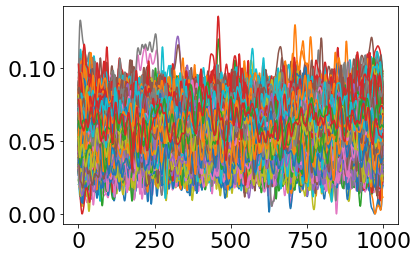

In [1274]:
# plt.figure()
# for k in range(train_images.shape[0]):
#     for i in range(train_images.shape[1]):
#         plt.plot(train_images[k][i])

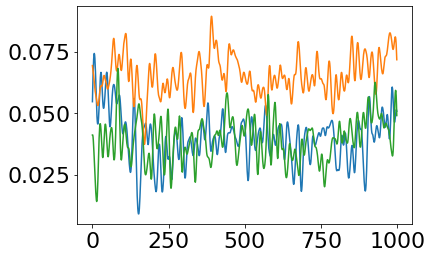

In [1275]:
# sampling = [0,100,200]
# for i in sampling:
#     plt.plot(train_images[i][0])

# CNN

In [10]:
# Reshape the images. Only when using Conv2D and MaxPooling2D
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
valid_images = np.expand_dims(valid_images, axis=3)

print(train_images.shape)
print(train_labels.shape)

(7512, 2, 1000, 1)
(7512,)


In [11]:
test_labels[0:10]

array([2, 2, 2, 0, 1, 2, 0, 1, 0, 2])

In [53]:
# # Build the model.

# model_cnn = Sequential()

# model_cnn.add(Conv1D(32,100,input_shape=(2, 1000, 1),activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,3)))

# model_cnn.add(Conv1D(64,50,activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,2)))

# # new layer
# model_cnn.add(Conv1D(128,50,activation='relu'))
# model_cnn.add(Conv1D(32,25,activation='relu'))
# model_cnn.add(MaxPooling2D(pool_size=(1,2)))

# model_cnn.add(Flatten())
# model_cnn.add(Dropout(0.5))

# model_cnn.add(Dense(1024,activation='relu'))
# model_cnn.add(Dense(2,activation='softmax'))
# model_cnn.summary()

# Build the model.

model_cnn = Sequential()

model_cnn.add(Conv1D(16,100,input_shape=(2, 1000, 1),activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1,3)))

model_cnn.add(Conv1D(32,50,activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1,2)))

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(1024,activation='relu'))
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 2, 901, 16)        1616      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 300, 16)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2, 251, 32)        25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 125, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)              

In [16]:
# Compile the model.

# Chnage the learning rate decay to prevent the acc from stucking at 50.00%
# as is mentioned in https://github.com/keras-team/keras/issues/1597
from tensorflow.keras import optimizers
op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.001, amsgrad=False)


model_cnn.compile(
  optimizer=op,
  loss='categorical_crossentropy',
  metrics=['acc'],
)

from keras import backend as K
# K.set_value(model_cnn.optimizer.learning_rate, 0.001)

# Train the model.
history_cnn = model_cnn.fit(
    train_images,
    to_categorical(train_labels),
    batch_size=16,
    epochs=100,
    validation_data=(test_images, to_categorical(test_labels)),
)

Epoch 1/100
470/470 [==============================] - 45s 96ms/step - loss: 1.0531 - acc: 0.4200 - val_loss: 0.9525 - val_acc: 0.5256
Epoch 2/100
470/470 [==============================] - 45s 96ms/step - loss: 0.8858 - acc: 0.5442 - val_loss: 0.7573 - val_acc: 0.6605
Epoch 3/100
470/470 [==============================] - 45s 96ms/step - loss: 0.7714 - acc: 0.6302 - val_loss: 0.6791 - val_acc: 0.7117
Epoch 4/100
470/470 [==============================] - 45s 96ms/step - loss: 0.7087 - acc: 0.6543 - val_loss: 0.6156 - val_acc: 0.7149
Epoch 5/100
470/470 [==============================] - 45s 96ms/step - loss: 0.6590 - acc: 0.6699 - val_loss: 0.5795 - val_acc: 0.7348
Epoch 6/100
470/470 [==============================] - 45s 96ms/step - loss: 0.6247 - acc: 0.6828 - val_loss: 0.5374 - val_acc: 0.7332
Epoch 7/100
470/470 [==============================] - 46s 97ms/step - loss: 0.6106 - acc: 0.6856 - val_loss: 0.5344 - val_acc: 0.7348
Epoch 8/100
470/470 [==============================] - 

470/470 [==============================] - 46s 99ms/step - loss: 0.3003 - acc: 0.8765 - val_loss: 0.2381 - val_acc: 0.9289
Epoch 62/100
470/470 [==============================] - 46s 99ms/step - loss: 0.2939 - acc: 0.8787 - val_loss: 0.2342 - val_acc: 0.9329
Epoch 63/100
470/470 [==============================] - 47s 100ms/step - loss: 0.2917 - acc: 0.8819 - val_loss: 0.2344 - val_acc: 0.9345
Epoch 64/100
470/470 [==============================] - 49s 104ms/step - loss: 0.2890 - acc: 0.8849 - val_loss: 0.2318 - val_acc: 0.9329
Epoch 65/100
470/470 [==============================] - 46s 98ms/step - loss: 0.2905 - acc: 0.8806 - val_loss: 0.2311 - val_acc: 0.9217
Epoch 66/100
470/470 [==============================] - 46s 98ms/step - loss: 0.2912 - acc: 0.8854 - val_loss: 0.2382 - val_acc: 0.9089
Epoch 67/100
470/470 [==============================] - 46s 98ms/step - loss: 0.2798 - acc: 0.8854 - val_loss: 0.2262 - val_acc: 0.9273
Epoch 68/100
470/470 [==============================] - 46s

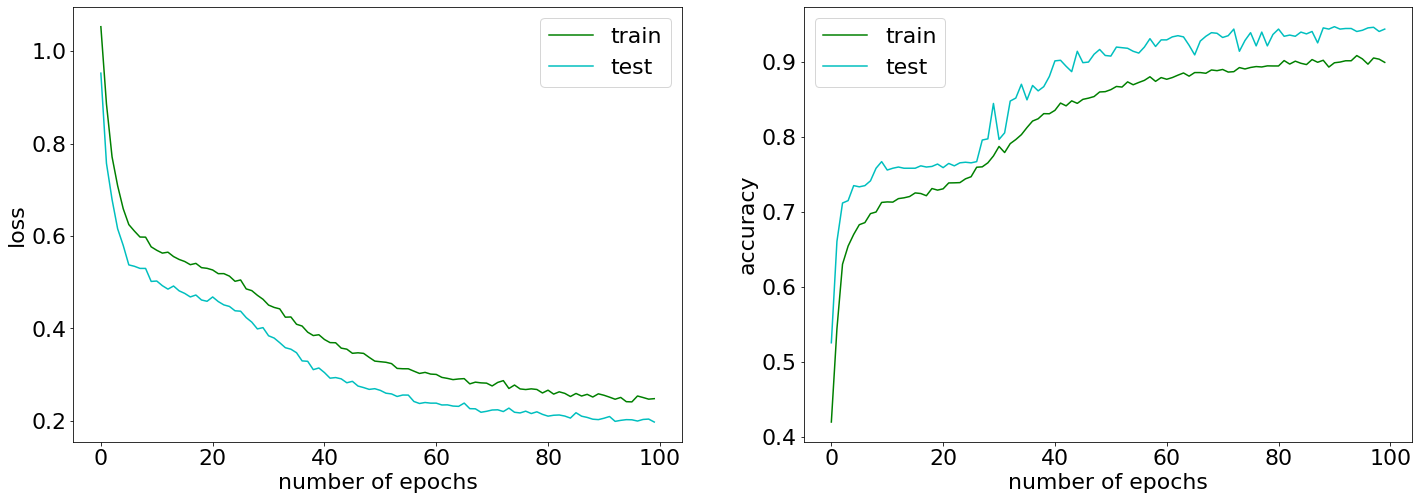

In [41]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
nepochs = len(history_cnn.history['loss'])
plt.plot(range(nepochs), history_cnn.history['loss'], 'g-', label='train')
plt.plot(range(nepochs), history_cnn.history['val_loss'], 'c-', label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('number of epochs')

plt.subplot(1,2,2)
nepochs = len(history_cnn.history['acc'])
plt.plot(range(nepochs), history_cnn.history['acc'], 'g-', label='train')
plt.plot(range(nepochs), history_cnn.history['val_acc'], 'c-', label='test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('number of epochs')

plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_1301.jpg")

In [19]:
# Save the model to disk.
model_cnn.save_weights('..\data\data3_attention\cnn_attention_f16_1301.h5')

# Batch process

In [58]:
def run_pipeline(fname):
    
    print("===============================================")
    print("------Run:", fname)
    exclude = fname.split('.')[0][-4:]
    print("------Test Subject #", exclude, " using a model trained by data of all other subjects.")
    
    f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    data, labels = pickle.load(f)
    f.close()
    print("data shape:   ", data.shape)
    print("labels shape: ", labels.shape)
    data, labels = shuffle(data, labels)
    print("------Shuffled.")

    total_samples = data.shape[0]
    trn, tst, vld = list(map(int, [0.6*total_samples, 
                                   0.1*total_samples, 
                                   0.3*total_samples]))
    print(trn, tst, vld)

    train_images = data[:trn, :, :]
    train_labels = labels[:trn,]
    test_images  = data[trn:trn + tst, :, :]
    test_labels  = labels[trn:trn + tst,]
    valid_images = data[trn + tst:trn + tst + vld, :, :]
    valid_labels = labels[trn + tst:trn + tst + vld,]

    print("------Check distribution:")
    from collections import Counter
    d = Counter(train_labels)
    print("Train:", d)
    d = Counter(test_labels)
    print("Valid:", d)

    print("------Print shape:")

    # Reshape the images. Only when using Conv2D and MaxPooling2D
    train_images = np.expand_dims(train_images, axis=3)
    test_images = np.expand_dims(test_images, axis=3)
    valid_images = np.expand_dims(valid_images, axis=3)

    print(train_images.shape)
    print(test_images.shape)
    print(valid_images.shape)

    print(train_labels[1:10])

    print(train_labels.shape)
    print(test_labels.shape)
    print(valid_labels.shape)


    print("------Build the model:")
    model_cnn = Sequential()

    model_cnn.add(Conv1D(16,100,input_shape=(2, 1000, 1),activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1,3)))

    model_cnn.add(Conv1D(32,50,activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1,2)))

    model_cnn.add(Flatten())
    model_cnn.add(Dropout(0.5))

    model_cnn.add(Dense(512,activation='relu'))
    model_cnn.add(Dense(3, activation='softmax'))
    model_cnn.summary()

    # Compile the model.
    print("------Compile the model.")
    from tensorflow.keras import optimizers
    op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.001, amsgrad=False)

    model_cnn.compile(
      optimizer=op,
      loss='categorical_crossentropy',
      metrics=['acc'],
    )

    print("------Train the model:")
    history_cnn = model_cnn.fit(
        train_images,
        to_categorical(train_labels),
        batch_size=16,
        epochs=100,
        validation_data=(test_images, to_categorical(test_labels)),
    )


    plt.figure(figsize=(24,8))

    plt.subplot(1,2,1)
    nepochs = len(history_cnn.history['loss'])
    plt.plot(range(nepochs), history_cnn.history['loss'], 'g-', label='train')
    plt.plot(range(nepochs), history_cnn.history['val_loss'], 'c-', label='test')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('number of epochs')

    plt.subplot(1,2,2)
    nepochs = len(history_cnn.history['acc'])
    plt.plot(range(nepochs), history_cnn.history['acc'], 'g-', label='train')
    plt.plot(range(nepochs), history_cnn.history['val_acc'], 'c-', label='test')
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('number of epochs')

    plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_"+exclude+".jpg")
    
    
    print("------Test the model on its test set:")
    pred_prob = model_cnn.predict(valid_images)
    pred_labels = []
    for encode in pred_prob:
        category = np.where(encode==np.amax(encode))[0][0]
        pred_labels.append(category)
    pred_labels = np.array(pred_labels)

    classes = [0,1,2]
    # argmax: reverse the to_categorical operation
    con_mat = confusion_matrix(valid_labels, predictions=pred_labels).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)
    figure = plt.figure(figsize=(4,4))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    truecases = con_mat[0][0] + con_mat[1][1] + con_mat[2][2]
    totalcases = len(pred_labels)


    print("Accuracy:", truecases/totalcases)
    print("Confusion matrix:")
    for i in con_mat:
        print(i)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_"+exclude+"_selftest.jpg")

    # Save the model to disk.
    model_cnn.save_weights(r"..\data\data3_attention\cnn_attention_f16_"+exclude+".h5")

    
    print("------Test the model on the excluded subject:")
    tname = "attention_"+exclude+"_low_fp1fp2_2s_resampled500Hz.pkl"
    f = open(os.path.join(r"..\data\data3_attention", tname), 'rb')
    data1, labels1 = pickle.load(f)
    f.close()

    data1, labels1 = shuffle(data1, labels1)

    total_samples1 = data1.shape[0]
    trn1, tst1, vld1 = list(map(int, [0*total_samples1, 
                                   0*total_samples1, 
                                   1*total_samples1]))

    valid_images1 = data1[trn1 + tst1:trn1 + tst1 + vld1, :, :]
    valid_labels1 = labels1[trn1 + tst1:trn1 + tst1 + vld1,]
    valid_images1 = np.expand_dims(valid_images1, axis=3)

    print(valid_images1.shape)
    print(valid_labels1.shape)
    
    # Predict.
    pred_prob1 = model_cnn.predict(valid_images1)
    pred_labels1 = []
    for encode in pred_prob1:
        category = np.where(encode==np.amax(encode))[0][0]
        pred_labels1.append(category)
    pred_labels1 = np.array(pred_labels1)

    classes = [0,1,2]
    # argmax: reverse the to_categorical operation
    con_mat1 = confusion_matrix(valid_labels1, predictions=pred_labels1).numpy()
    con_mat_norm1 = np.around(con_mat1.astype('float') / con_mat1.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df1 = pd.DataFrame(con_mat_norm1,
                         index = classes, 
                         columns = classes)
    figure = plt.figure(figsize=(4,4))
    sns.heatmap(con_mat_df1, annot=True,cmap=plt.cm.Blues)
    truecases1 = con_mat1[0][0] + con_mat1[1][1] + con_mat1[2][2]
    totalcases1 = len(pred_labels1)

    print("Accuracy:", truecases1/totalcases1)
    print("Confusion matrix:")
    for i in con_mat1:
        print(i)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(r"..\data\data3_attention\fig\cnn_attention_f16_"+exclude+"_singletest.jpg")

In [60]:
to_run =[
 'attention_f16_0002.pkl',
 'attention_f16_0004.pkl',
 'attention_f16_0005.pkl',
 'attention_f16_0006.pkl',
 'attention_f16_0007.pkl',
 'attention_f16_0009.pkl',
 'attention_f16_0013.pkl',
 'attention_f16_0201.pkl',
 'attention_f16_0401.pkl',
 'attention_f16_0502.pkl',
 'attention_f16_0601.pkl',
 'attention_f16_0701.pkl',
 'attention_f16_0801.pkl',
 'attention_f16_0901.pkl',
 'attention_f16_1101.pkl',
 'attention_f16_1301.pkl'
]

for fname in to_run:
    run_pipeline(fname)

------Run: attention_f16_0002.pkl
------Test Subject # 0002  using a model trained by data of all other subjects.
data shape:    (12521, 2, 1000)
labels shape:  (12521,)
------Shuffled.
7512 1252 3756
------Check distribution:
Train: Counter({0: 2545, 2: 2486, 1: 2481})
Valid: Counter({2: 442, 1: 419, 0: 391})
------Print shape:
(7512, 2, 1000, 1)
(1252, 2, 1000, 1)
(3756, 2, 1000, 1)
[1 0 1 1 1 2 1 0 0]
(7512,)
(1252,)
(3756,)
------Build the model:
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 2, 901, 16)        1616      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 300, 16)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2, 251, 32)        25632     
____________________________________________________________

KeyboardInterrupt: 

# Test

In [91]:
# Load the trained model from disk
model_cnn.load_weights('..\data\data3_attention\cnn_attention_f16_0002.h5')

In [22]:
# ================== Select your test data ==========================

fname = "attention_1301_low_fp1fp2_2s_resampled500Hz.pkl"
f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
data, labels = pickle.load(f)
f.close()

print(data.shape)
print(labels.shape)

data, labels = shuffle(data, labels)

total_samples = data.shape[0]
trn, tst, vld = list(map(int, [0*total_samples, 
                               0*total_samples, 
                               1*total_samples]))
print("trn, tst, vld:", trn, tst, vld)


valid_images = data[trn + tst:trn + tst + vld, :, :]
valid_labels = labels[trn + tst:trn + tst + vld,]
valid_images = np.expand_dims(valid_images, axis=3)

valid_images = np.expand_dims(valid_images, axis=3)

print(valid_images.shape)
print(valid_labels.shape)


(837, 2, 1000)
(837,)
trn, tst, vld: 0 0 837
(837, 2, 1000, 1, 1)
(837,)


Accuracy: 0.6726403823178017
Confusion matrix:
[  8   0 271]
[  0 279   0]
[  0   3 276]


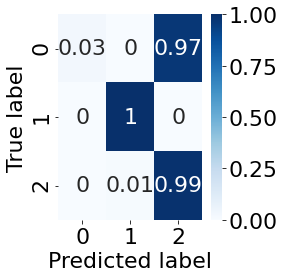

In [23]:
# Predict.
pred_prob = model_cnn.predict(valid_images)
pred_labels = []
for encode in pred_prob:
    category = np.where(encode==np.amax(encode))[0][0]
    pred_labels.append(category)
pred_labels = np.array(pred_labels)

# Triple

classes = [0,1,2]
# argmax: reverse the to_categorical operation
con_mat = confusion_matrix(valid_labels, predictions=pred_labels).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(4,4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
truecases = con_mat[0][0] + con_mat[1][1] + con_mat[2][2]
totalcases = len(pred_labels)


print("Accuracy:", truecases/totalcases)
print("Confusion matrix:")
for i in con_mat:
    print(i)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Cross test

In [2]:
# ================== Select your test data ==========================
def get_test_data(fname):
    f = open(os.path.join(r"..\data\data3_attention", fname), 'rb')
    data, labels = pickle.load(f)
    f.close()
    data, labels = shuffle(data, labels)

    total_samples = data.shape[0]
    trn, tst, vld = list(map(int, [0*total_samples, 
                                   0*total_samples, 
                                   0.4*total_samples]))
    print("Test samples:", vld)

    valid_images = data[trn + tst:trn + tst + vld, :, :]
    valid_labels = labels[trn + tst:trn + tst + vld,]
    valid_images = np.expand_dims(valid_images, axis=3)

    valid_images = np.expand_dims(valid_images, axis=3)

    return valid_images, valid_labels

def mypredict(valid_images):
    # Predict.
    pred_prob = model_cnn.predict(valid_images)
    pred_labels = []
    for encode in pred_prob:
        category = np.where(encode==np.amax(encode))[0][0]
        pred_labels.append(category)
    pred_labels = np.array(pred_labels)

    # Triple

    classes = [0,1,2]
    # argmax: reverse the to_categorical operation
    con_mat = confusion_matrix(valid_labels, predictions=pred_labels).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)
    figure = plt.figure(figsize=(4,4))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    truecases = con_mat[0][0] + con_mat[1][1] + con_mat[2][2]
    totalcases = len(pred_labels)

    accuracy = truecases/totalcases
    print("Accuracy:", truecases/totalcases)
    print("Confusion matrix:")
    for i in con_mat:
        print(i)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return accuracy, con_mat

Model trained on: Subject # 0002
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[107   0   0]
[  0 120   0]
[  0   0 107]


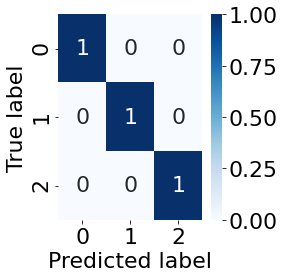

Model trained on: Subject # 0002
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 114]
[  0   0 114]
[106   0   0]


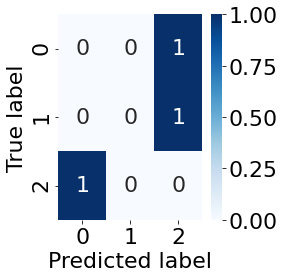

Model trained on: Subject # 0002
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 101]
[120   0   0]
[  0 113   0]


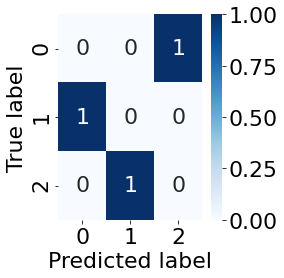

Model trained on: Subject # 0002
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.3502994011976048
Confusion matrix:
[  0 104   0]
[  0 117   0]
[  0 113   0]


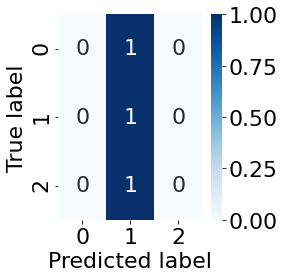

Model trained on: Subject # 0002
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6706586826347305
Confusion matrix:
[95  0  0]
[  0 129   0]
[  0 110   0]


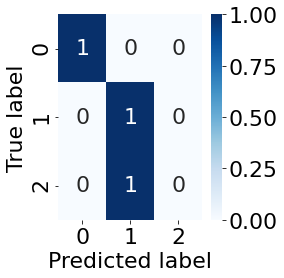

Model trained on: Subject # 0002
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.6736526946107785
Confusion matrix:
[103   0   0]
[  0 122   0]
[  2 107   0]


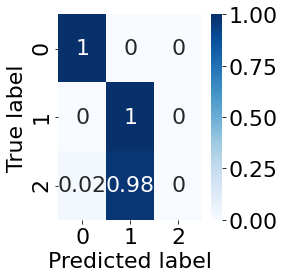

Model trained on: Subject # 0002
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.3203592814371258
Confusion matrix:
[  0 117   0]
[  0 107   0]
[  0 110   0]


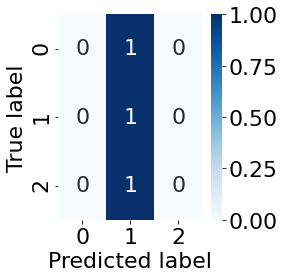

Model trained on: Subject # 0002
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.2887537993920973
Confusion matrix:
[  0   0 111]
[  0   0 116]
[ 7  0 95]


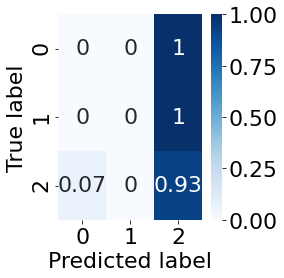

Model trained on: Subject # 0002
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3282674772036474
Confusion matrix:
[  0   0 103]
[  1   0 109]
[  8   0 108]


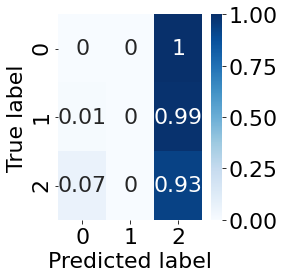

Model trained on: Subject # 0002
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3532934131736527
Confusion matrix:
[117   0   0]
[102   1   0]
[114   0   0]


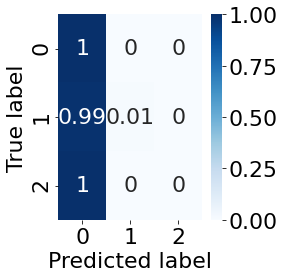

Model trained on: Subject # 0002
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.3413173652694611
Confusion matrix:
[  0   0 103]
[  0   0 117]
[  0   0 114]


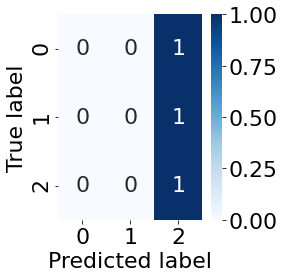

Model trained on: Subject # 0002
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.6916167664670658
Confusion matrix:
[127   0   0]
[  0   0 103]
[  0   0 104]


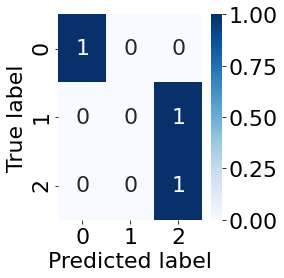

Model trained on: Subject # 0002
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.2964071856287425
Confusion matrix:
[99  0  0]
[118   0   0]
[  0 117   0]


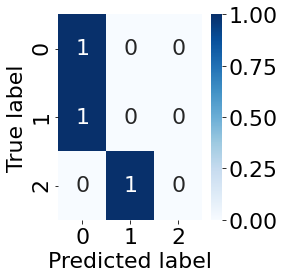

Model trained on: Subject # 0002
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[  0 109   0]
[  0 105   0]
[  0 120   0]


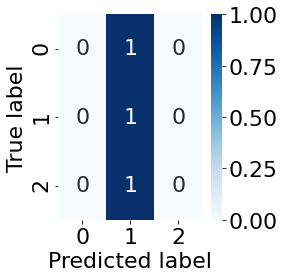

Model trained on: Subject # 0002
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.32934131736526945
Confusion matrix:
[  0 120   0]
[  0 110   0]
[104   0   0]


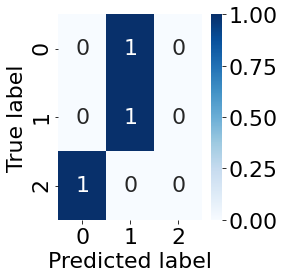

Model trained on: Subject # 0002
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6736526946107785
Confusion matrix:
[119   0   0]
[  0 106   0]
[  0 109   0]


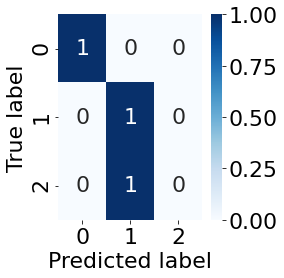

Model trained on: Subject # 0004
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.11676646706586827
Confusion matrix:
[38  0 75]
[  0   0 115]
[105   0   1]


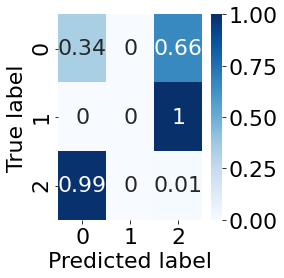

Model trained on: Subject # 0004
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[119   0   0]
[  0 102   0]
[  0   0 113]


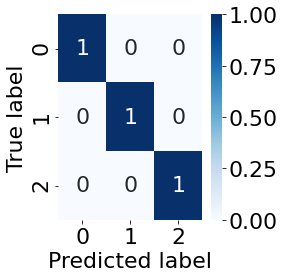

Model trained on: Subject # 0004
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.6826347305389222
Confusion matrix:
[114   0   0]
[  0   0 106]
[  0   0 114]


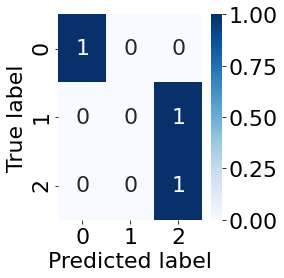

Model trained on: Subject # 0004
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 114]
[117   0   0]
[  0 103   0]


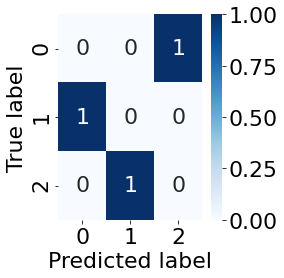

Model trained on: Subject # 0004
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6826347305389222
Confusion matrix:
[  0   0 106]
[  0 113   0]
[  0   0 115]


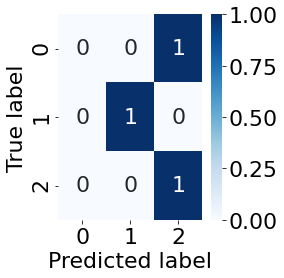

Model trained on: Subject # 0004
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.655688622754491
Confusion matrix:
[113   0   0]
[  0 106   0]
[  0 115   0]


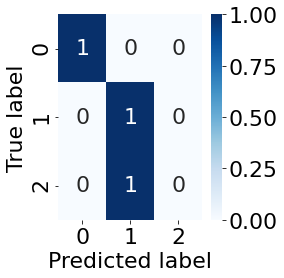

Model trained on: Subject # 0004
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 112]
[  0 115   0]
[  0 107   0]


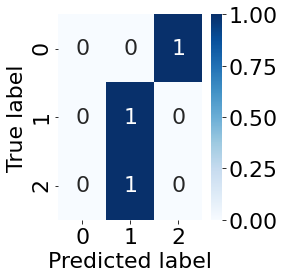

Model trained on: Subject # 0004
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3708206686930091
Confusion matrix:
[  0   0 103]
[  0   0 104]
[  0   0 122]


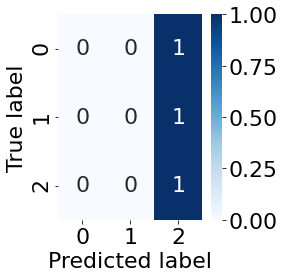

Model trained on: Subject # 0004
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3100303951367781
Confusion matrix:
[  0   0 108]
[  0   0 119]
[  0   0 102]


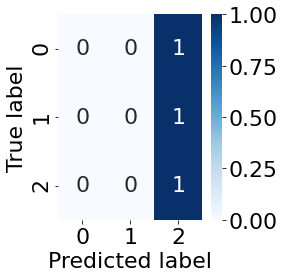

Model trained on: Subject # 0004
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0   0 115]
[  0   0 107]
[  0   0 112]


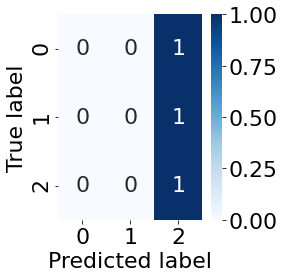

Model trained on: Subject # 0004
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.3652694610778443
Confusion matrix:
[122   0   0]
[113   0   0]
[99  0  0]


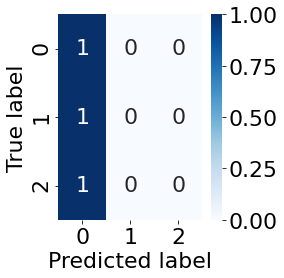

Model trained on: Subject # 0004
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 127]
[87  0  0]
[120   0   0]


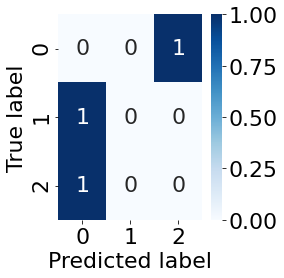

Model trained on: Subject # 0004
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.30538922155688625
Confusion matrix:
[  0   0 126]
[  0   0 106]
[  0   0 102]


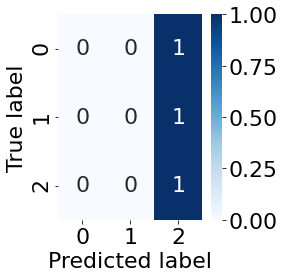

Model trained on: Subject # 0004
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3413173652694611
Confusion matrix:
[  0 118   0]
[  0 114   0]
[  0 102   0]


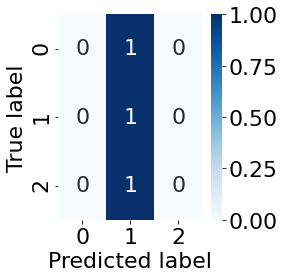

Model trained on: Subject # 0004
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.3592814371257485
Confusion matrix:
[  0   0 108]
[  0 120   0]
[106   0   0]


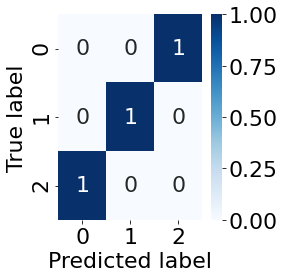

Model trained on: Subject # 0004
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 110]
[  0 115   0]
[  0 109   0]


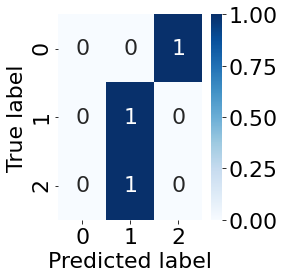

Model trained on: Subject # 0005
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.38323353293413176
Confusion matrix:
[ 0 97  0]
[  0 128   0]
[109   0   0]


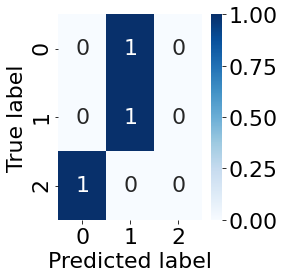

Model trained on: Subject # 0005
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.3383233532934132
Confusion matrix:
[113   0   0]
[112   0   0]
[  0 109   0]


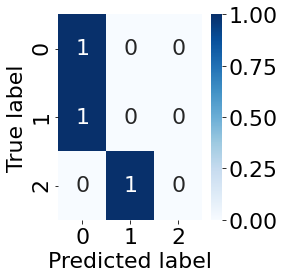

Model trained on: Subject # 0005
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[114   0   0]
[  0 113   0]
[  0   0 107]


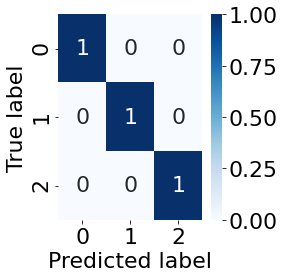

Model trained on: Subject # 0005
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.30538922155688625
Confusion matrix:
[  0 108   0]
[  0 102   0]
[  0 124   0]


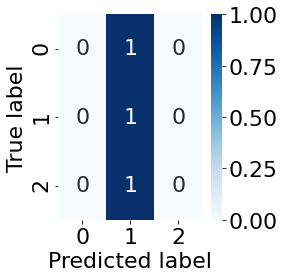

Model trained on: Subject # 0005
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[  0 108   0]
[  0 116   0]
[  0   0 110]


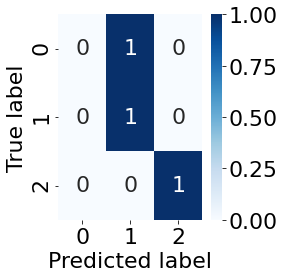

Model trained on: Subject # 0005
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0 103   0]
[  0 112   0]
[119   0   0]


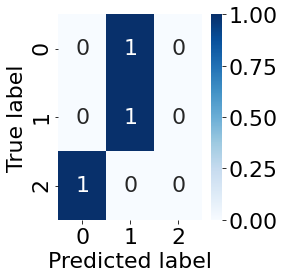

Model trained on: Subject # 0005
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0 120   0]
[  0 108   0]
[  0 106   0]


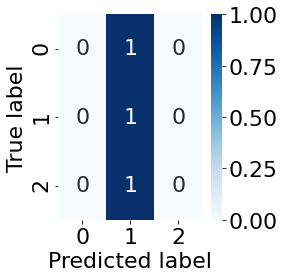

Model trained on: Subject # 0005
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3495440729483283
Confusion matrix:
[115   0   0]
[96  0  0]
[113   5   0]


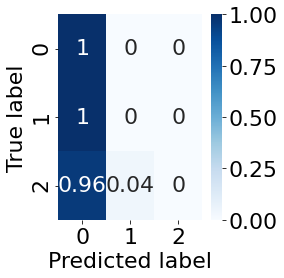

Model trained on: Subject # 0005
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3282674772036474
Confusion matrix:
[107   0   0]
[110   1   0]
[105   6   0]


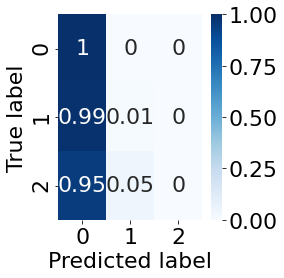

Model trained on: Subject # 0005
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0 102   0]
[  0 108   0]
[  0 124   0]


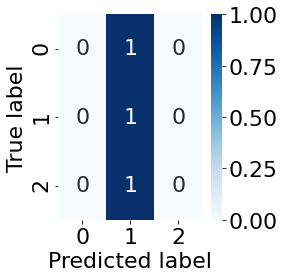

Model trained on: Subject # 0005
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.3323353293413174
Confusion matrix:
[111   0   0]
[105   0   0]
[118   0   0]


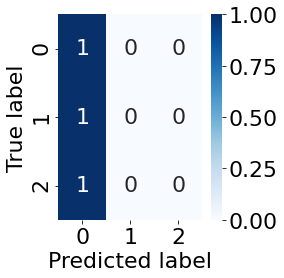

Model trained on: Subject # 0005
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0 112   0]
[113   0   0]
[109   0   0]


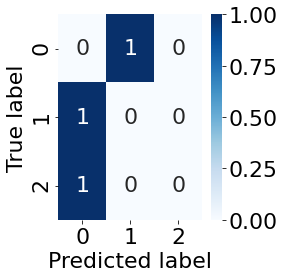

Model trained on: Subject # 0005
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.6676646706586826
Confusion matrix:
[  0 111   0]
[  0 113   0]
[  0   0 110]


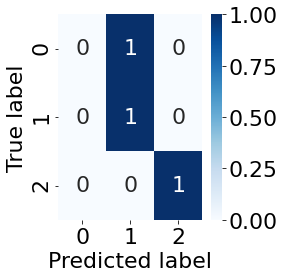

Model trained on: Subject # 0005
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0 101   0]
[  0   0 119]
[  1 113   0]


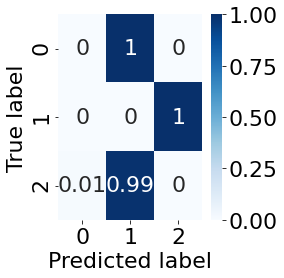

Model trained on: Subject # 0005
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0 101   0]
[  0   0 119]
[  0 114   0]


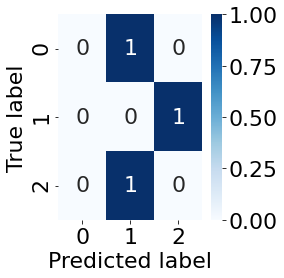

Model trained on: Subject # 0005
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.3203592814371258
Confusion matrix:
[  0 117   0]
[  0 107   0]
[110   0   0]


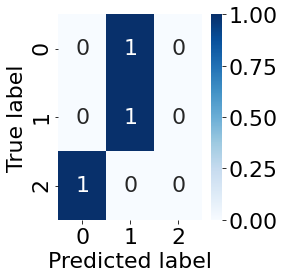

Model trained on: Subject # 0006
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.3473053892215569
Confusion matrix:
[116   0   0]
[100   0   0]
[118   0   0]


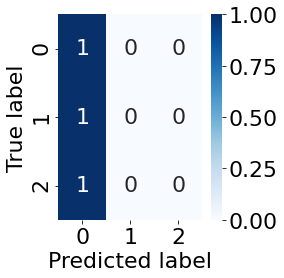

Model trained on: Subject # 0006
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.3263473053892216
Confusion matrix:
[109   0   0]
[107   0   0]
[118   0   0]


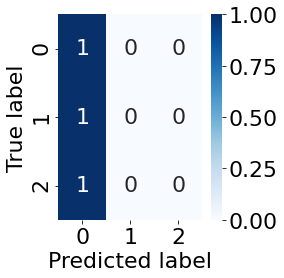

Model trained on: Subject # 0006
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[105   0   0]
[115   0   0]
[114   0   0]


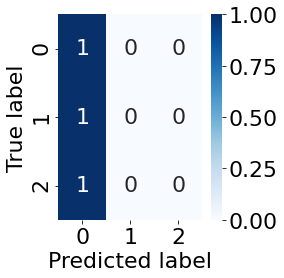

Model trained on: Subject # 0006
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.9970059880239521
Confusion matrix:
[108   0   0]
[  0 125   0]
[  0   1 100]


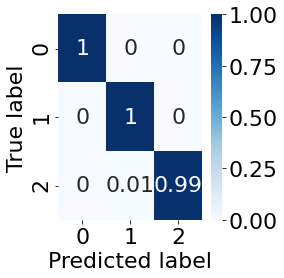

Model trained on: Subject # 0006
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[108   0   0]
[  0   0 124]
[102   0   0]


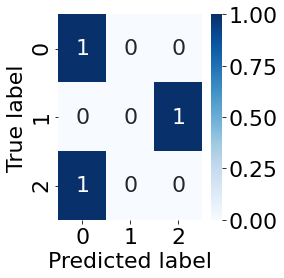

Model trained on: Subject # 0006
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[109   0   0]
[  0   0 108]
[  0   0 117]


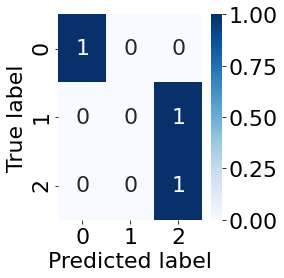

Model trained on: Subject # 0006
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.655688622754491
Confusion matrix:
[103   0   0]
[  0   0 115]
[  0   0 116]


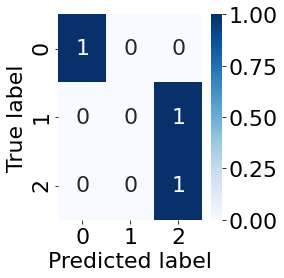

Model trained on: Subject # 0006
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3404255319148936
Confusion matrix:
[112   0   0]
[94  0  0]
[123   0   0]


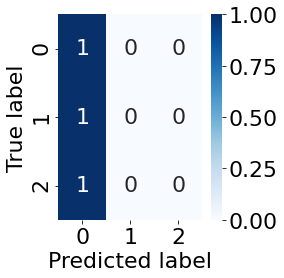

Model trained on: Subject # 0006
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3252279635258359
Confusion matrix:
[107   0   0]
[105   0   0]
[117   0   0]


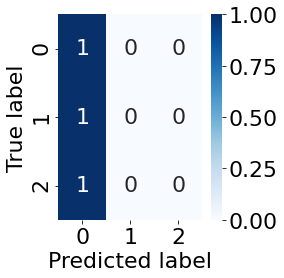

Model trained on: Subject # 0006
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3083832335329341
Confusion matrix:
[103   0   0]
[127   0   0]
[104   0   0]


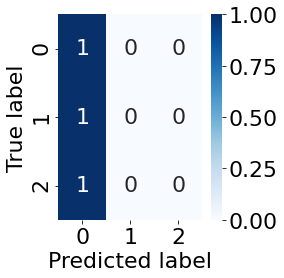

Model trained on: Subject # 0006
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.3592814371257485
Confusion matrix:
[120   0   0]
[97  0  0]
[117   0   0]


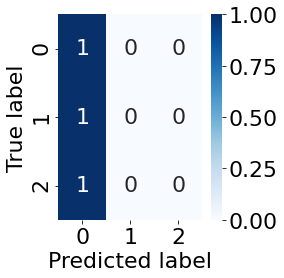

Model trained on: Subject # 0006
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.3473053892215569
Confusion matrix:
[116   0   0]
[98  0  0]
[120   0   0]


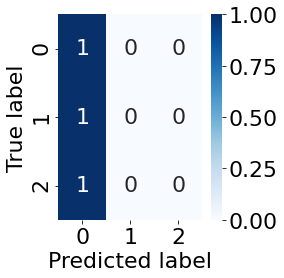

Model trained on: Subject # 0006
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3502994011976048
Confusion matrix:
[117   0   0]
[116   0   0]
[101   0   0]


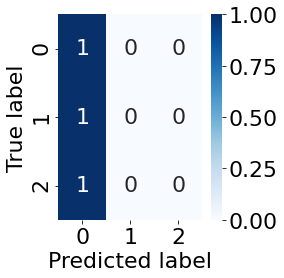

Model trained on: Subject # 0006
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.30538922155688625
Confusion matrix:
[  0   0 116]
[  0   0 116]
[  0   0 102]


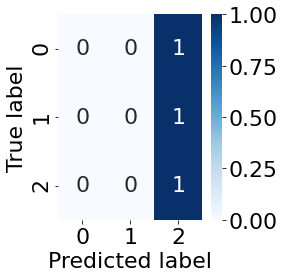

Model trained on: Subject # 0006
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[112   0   0]
[  0   0 112]
[110   0   0]


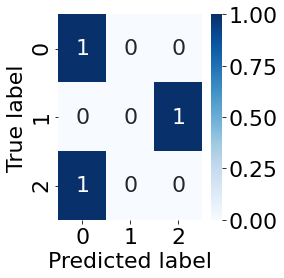

Model trained on: Subject # 0006
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[102   0   0]
[  0   0 108]
[  0   0 124]


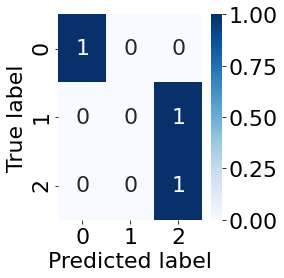

Model trained on: Subject # 0007
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.3562874251497006
Confusion matrix:
[119   0   0]
[ 0  0 98]
[117   0   0]


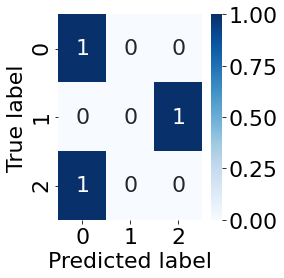

Model trained on: Subject # 0007
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.3562874251497006
Confusion matrix:
[119   0   0]
[105   0   0]
[110   0   0]


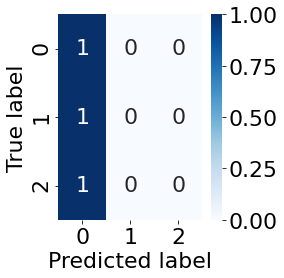

Model trained on: Subject # 0007
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[112   0   0]
[108   0   0]
[  0   0 114]


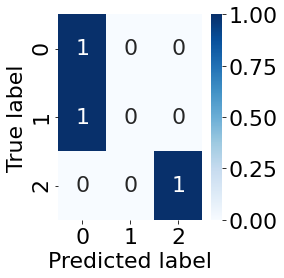

Model trained on: Subject # 0007
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.05089820359281437
Confusion matrix:
[  0   0 112]
[ 0 17 94]
[  0 111   0]


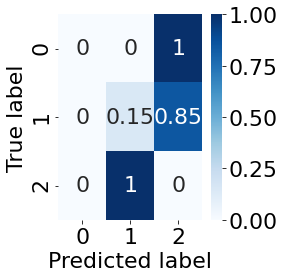

Model trained on: Subject # 0007
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[107   0   0]
[  0 109   0]
[  0   0 118]


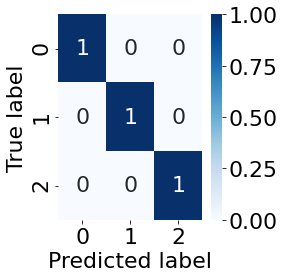

Model trained on: Subject # 0007
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.6796407185628742
Confusion matrix:
[111   0   0]
[  0 116   0]
[  1 106   0]


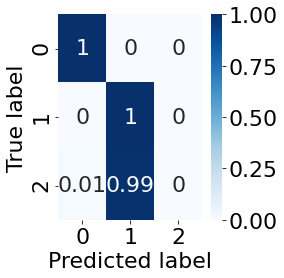

Model trained on: Subject # 0007
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.6706586826347305
Confusion matrix:
[111   0   0]
[  0 113   0]
[  0 110   0]


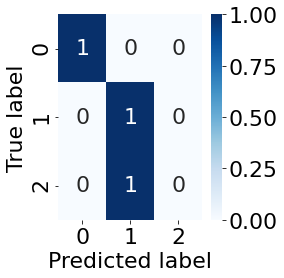

Model trained on: Subject # 0007
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.2978723404255319
Confusion matrix:
[98  0  0]
[110   0   0]
[121   0   0]


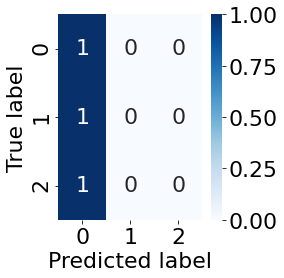

Model trained on: Subject # 0007
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3617021276595745
Confusion matrix:
[119   0   0]
[106   0   0]
[104   0   0]


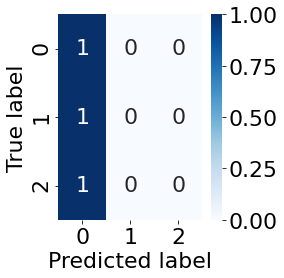

Model trained on: Subject # 0007
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3532934131736527
Confusion matrix:
[118   0   0]
[109   0   0]
[107   0   0]


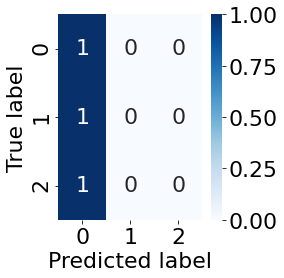

Model trained on: Subject # 0007
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[108   0   0]
[131   0   0]
[95  0  0]


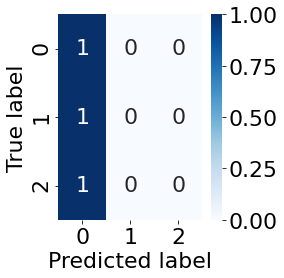

Model trained on: Subject # 0007
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.3502994011976048
Confusion matrix:
[117   0   0]
[115   0   0]
[102   0   0]


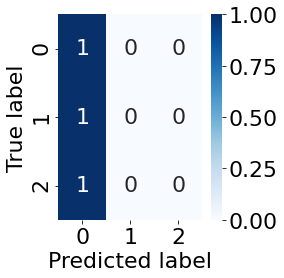

Model trained on: Subject # 0007
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.6586826347305389
Confusion matrix:
[112   0   0]
[114   0   0]
[  0   0 108]


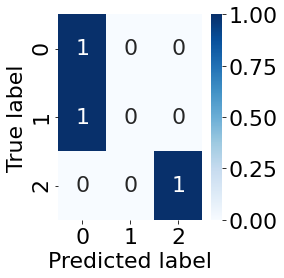

Model trained on: Subject # 0007
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0 117   0]
[  0 108   0]
[  0 109   0]


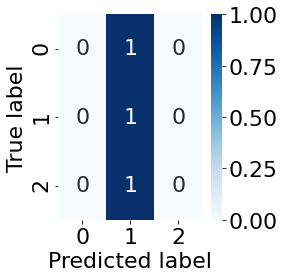

Model trained on: Subject # 0007
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.6437125748502994
Confusion matrix:
[109   0   0]
[  0 106   0]
[119   0   0]


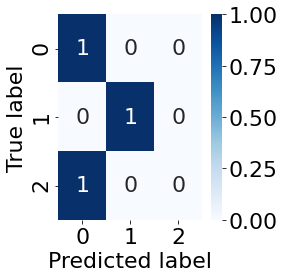

Model trained on: Subject # 0007
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6796407185628742
Confusion matrix:
[122   0   0]
[  0 105   0]
[  0 107   0]


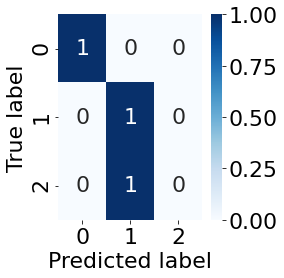

Model trained on: Subject # 0009
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.36227544910179643
Confusion matrix:
[121   0   0]
[104   0   0]
[109   0   0]


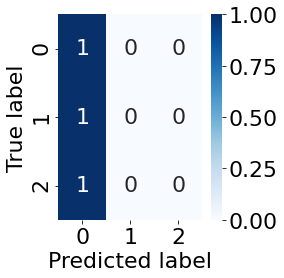

Model trained on: Subject # 0009
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.19461077844311378
Confusion matrix:
[65  0 49]
[  0   0 109]
[111   0   0]


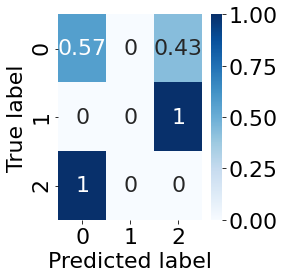

Model trained on: Subject # 0009
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[115   0   0]
[119   0   0]
[100   0   0]


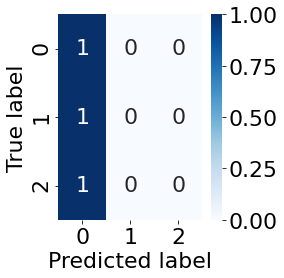

Model trained on: Subject # 0009
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.2904191616766467
Confusion matrix:
[97  0  0]
[126   0   0]
[94 17  0]


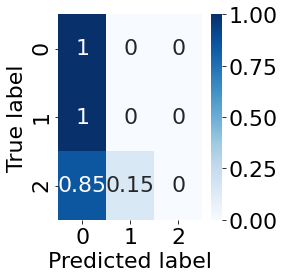

Model trained on: Subject # 0009
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6377245508982036
Confusion matrix:
[107   0   0]
[  0 106   0]
[121   0   0]


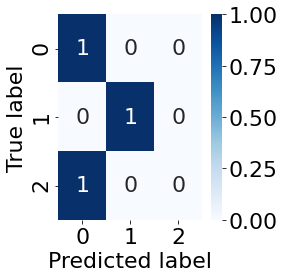

Model trained on: Subject # 0009
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[113   0   0]
[  0 105   0]
[  0   0 116]


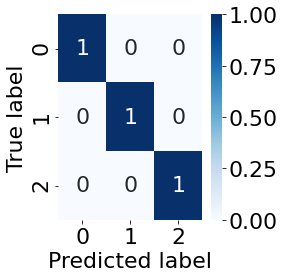

Model trained on: Subject # 0009
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.6676646706586826
Confusion matrix:
[114   0   0]
[  0 109   0]
[  0 111   0]


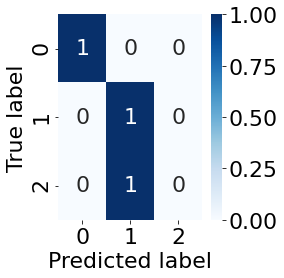

Model trained on: Subject # 0009
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3373860182370821
Confusion matrix:
[111   0   0]
[107   0   0]
[111   0   0]


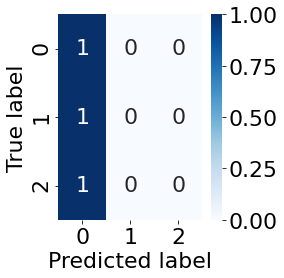

Model trained on: Subject # 0009
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3343465045592705
Confusion matrix:
[110   0   0]
[111   0   0]
[108   0   0]


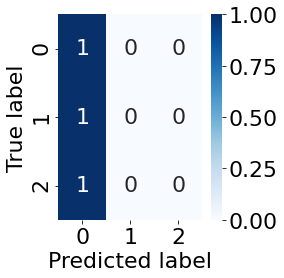

Model trained on: Subject # 0009
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3473053892215569
Confusion matrix:
[116   0   0]
[121   0   0]
[97  0  0]


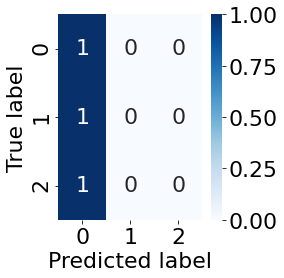

Model trained on: Subject # 0009
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.0029940119760479044
Confusion matrix:
[  1   0 102]
[123   0   0]
[108   0   0]


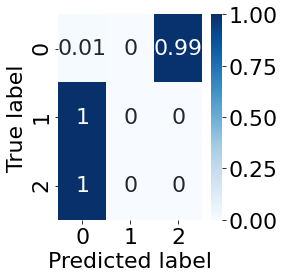

Model trained on: Subject # 0009
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[108   0   0]
[  0   0 105]
[121   0   0]


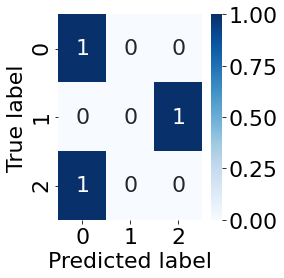

Model trained on: Subject # 0009
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3203592814371258
Confusion matrix:
[107   0   0]
[117   0   0]
[110   0   0]


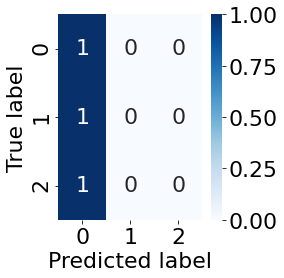

Model trained on: Subject # 0009
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3592814371257485
Confusion matrix:
[  0 103   0]
[  0 120   0]
[  0 111   0]


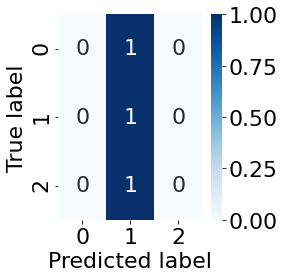

Model trained on: Subject # 0009
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.655688622754491
Confusion matrix:
[116   0   0]
[  0 103   0]
[115   0   0]


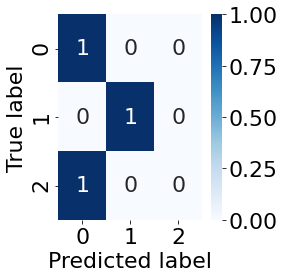

Model trained on: Subject # 0009
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6616766467065869
Confusion matrix:
[105   0   0]
[  0 116   0]
[  0 113   0]


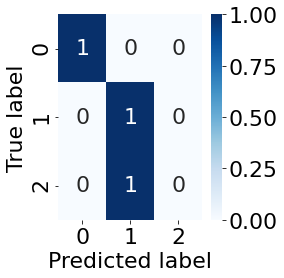

Model trained on: Subject # 0013
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.3263473053892216
Confusion matrix:
[109   0   0]
[102   0   9]
[114   0   0]


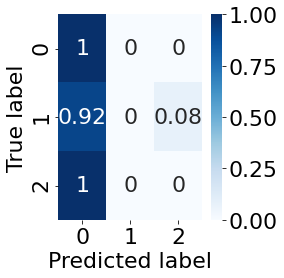

Model trained on: Subject # 0013
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.3383233532934132
Confusion matrix:
[113   0   0]
[106   0   0]
[115   0   0]


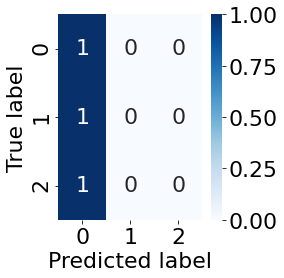

Model trained on: Subject # 0013
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.3023952095808383
Confusion matrix:
[101   0   0]
[117   0   0]
[116   0   0]


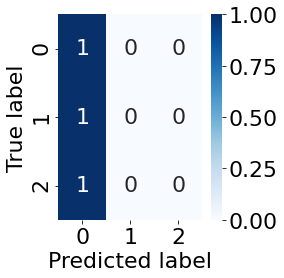

Model trained on: Subject # 0013
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.6586826347305389
Confusion matrix:
[114   0   0]
[  0   0 114]
[  0   0 106]


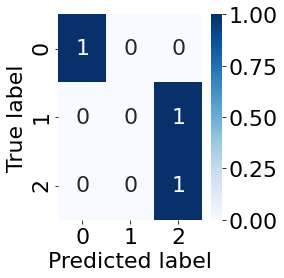

Model trained on: Subject # 0013
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[112   0   0]
[  0 114   0]
[108   0   0]


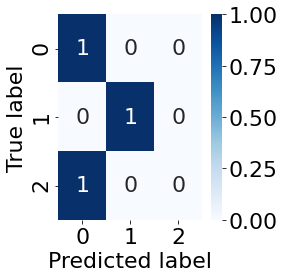

Model trained on: Subject # 0013
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.6826347305389222
Confusion matrix:
[117   0   0]
[  0   0 106]
[  0   0 111]


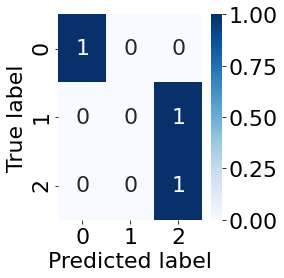

Model trained on: Subject # 0013
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[117   0   0]
[  0 111   0]
[  0   0 106]


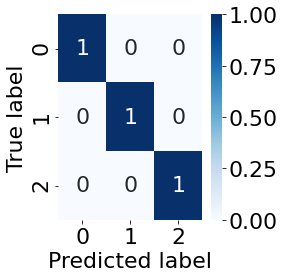

Model trained on: Subject # 0013
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3221884498480243
Confusion matrix:
[106   0   0]
[112   0   0]
[111   0   0]


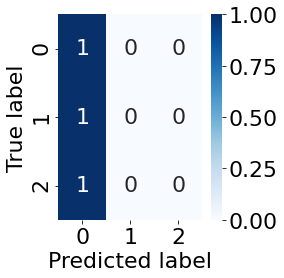

Model trained on: Subject # 0013
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3434650455927052
Confusion matrix:
[113   0   0]
[108   0   0]
[108   0   0]


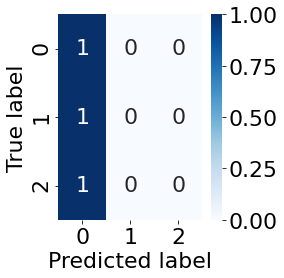

Model trained on: Subject # 0013
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[112   0   0]
[98  0  0]
[124   0   0]


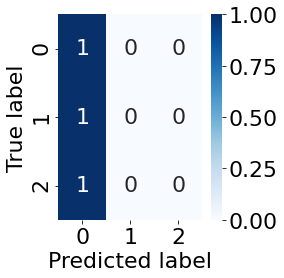

Model trained on: Subject # 0013
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[108   0   0]
[118   0   0]
[108   0   0]


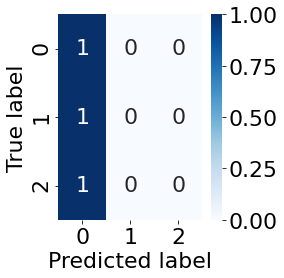

Model trained on: Subject # 0013
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.37425149700598803
Confusion matrix:
[125   0   0]
[103   0   0]
[106   0   0]


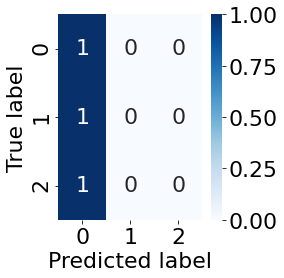

Model trained on: Subject # 0013
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3203592814371258
Confusion matrix:
[107   0   0]
[113   0   0]
[114   0   0]


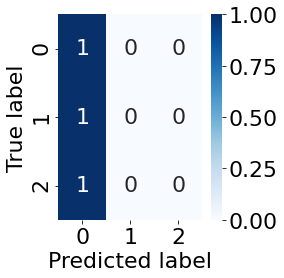

Model trained on: Subject # 0013
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[  0 110   0]
[  0 105   0]
[  0 119   0]


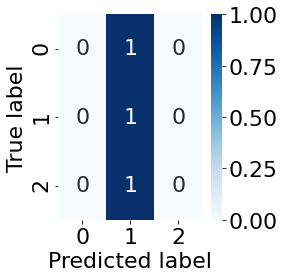

Model trained on: Subject # 0013
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.36826347305389223
Confusion matrix:
[123   0   0]
[  0   0 113]
[98  0  0]


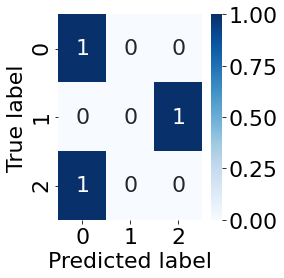

Model trained on: Subject # 0013
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[112   0   0]
[  0 114   0]
[  0 108   0]


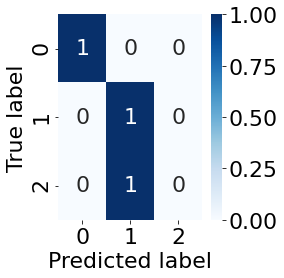

Model trained on: Subject # 0201
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.18263473053892215
Confusion matrix:
[40 30 35]
[42 21 47]
[119   0   0]


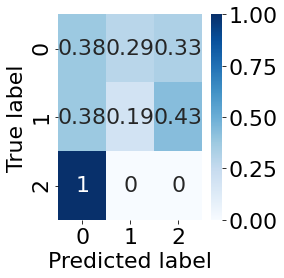

Model trained on: Subject # 0201
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.6916167664670658
Confusion matrix:
[129   0   0]
[103   0   0]
[  0   0 102]


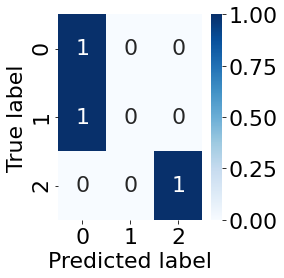

Model trained on: Subject # 0201
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.6706586826347305
Confusion matrix:
[119   0   0]
[  0   0 110]
[  0   0 105]


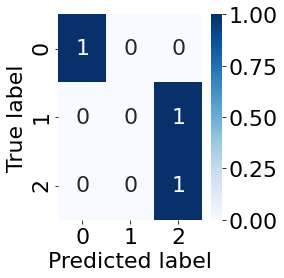

Model trained on: Subject # 0201
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.3502994011976048
Confusion matrix:
[117   0   0]
[118   0   0]
[99  0  0]


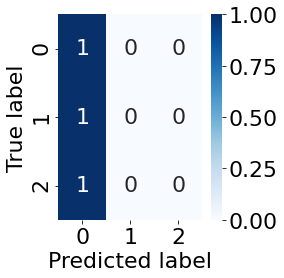

Model trained on: Subject # 0201
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.017964071856287425
Confusion matrix:
[  0  11 103]
[119   0   0]
[65 30  6]


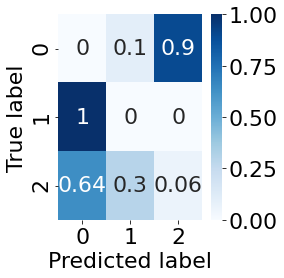

Model trained on: Subject # 0201
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.31137724550898205
Confusion matrix:
[104   0   0]
[106   0   0]
[124   0   0]


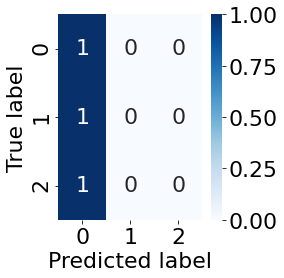

Model trained on: Subject # 0201
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[105   1   0]
[122   0   0]
[106   0   0]


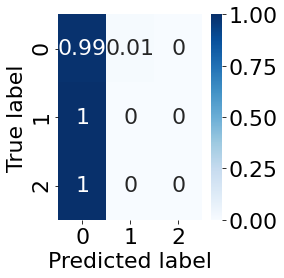

Model trained on: Subject # 0201
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.993920972644377
Confusion matrix:
[115   0   0]
[  0 105   1]
[  0   1 107]


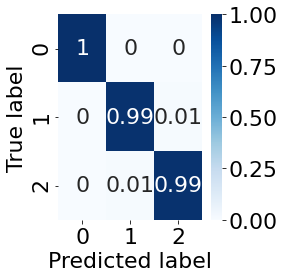

Model trained on: Subject # 0201
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.9969604863221885
Confusion matrix:
[117   0   0]
[ 0 95  1]
[  0   0 116]


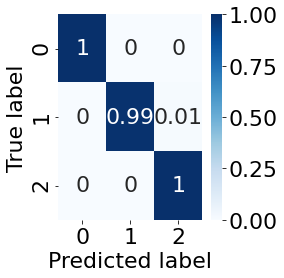

Model trained on: Subject # 0201
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 133]
[95  0  0]
[106   0   0]


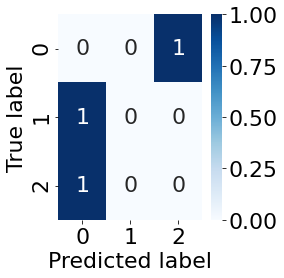

Model trained on: Subject # 0201
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.3652694610778443
Confusion matrix:
[122   0   0]
[99  0  0]
[113   0   0]


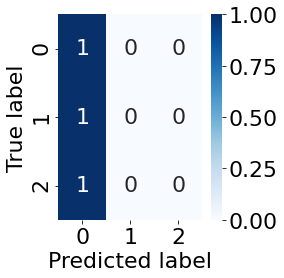

Model trained on: Subject # 0201
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 106]
[116   0   0]
[112   0   0]


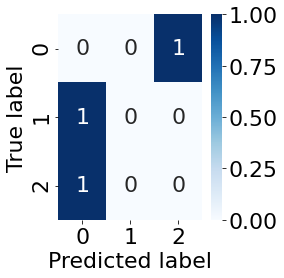

Model trained on: Subject # 0201
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3562874251497006
Confusion matrix:
[  0   0 113]
[  0   0 102]
[  0   0 119]


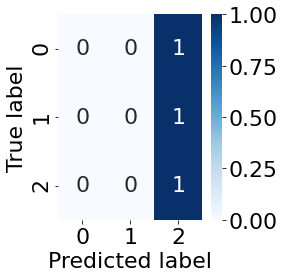

Model trained on: Subject # 0201
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3473053892215569
Confusion matrix:
[116   0   0]
[104   0   0]
[114   0   0]


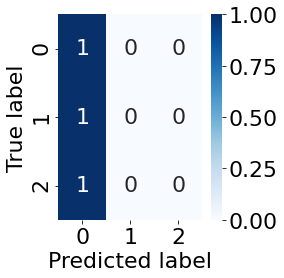

Model trained on: Subject # 0201
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 110]
[114   0   0]
[110   0   0]


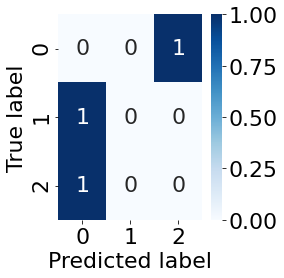

Model trained on: Subject # 0201
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 121]
[108   0   0]
[105   0   0]


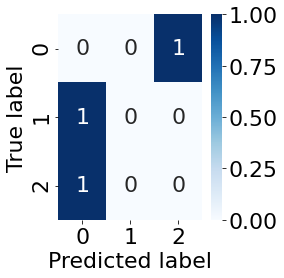

Model trained on: Subject # 0401
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.30538922155688625
Confusion matrix:
[101   0   5]
[104   0  10]
[113   0   1]


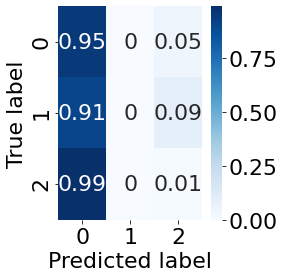

Model trained on: Subject # 0401
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.6706586826347305
Confusion matrix:
[112   0   0]
[110   0   0]
[  0   0 112]


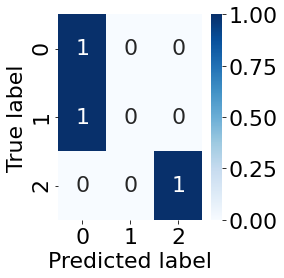

Model trained on: Subject # 0401
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[104   0   0]
[  0   0 108]
[  0   0 122]


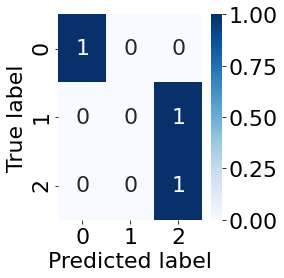

Model trained on: Subject # 0401
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.37425149700598803
Confusion matrix:
[125   0   0]
[110   0   0]
[99  0  0]


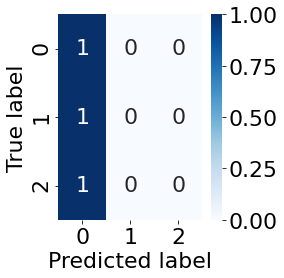

Model trained on: Subject # 0401
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.3323353293413174
Confusion matrix:
[111   0   1]
[102   0   0]
[120   0   0]


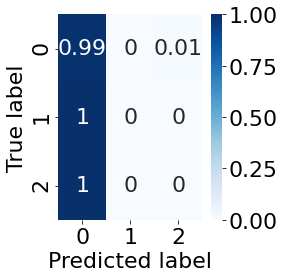

Model trained on: Subject # 0401
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.3562874251497006
Confusion matrix:
[119   0   0]
[102   0   0]
[113   0   0]


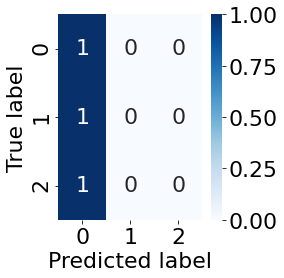

Model trained on: Subject # 0401
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[114   0   0]
[121   0   0]
[98  0  1]


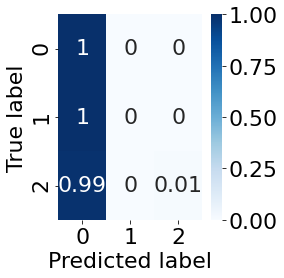

Model trained on: Subject # 0401
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.9635258358662614
Confusion matrix:
[105   0   0]
[  0 107   9]
[  0   3 105]


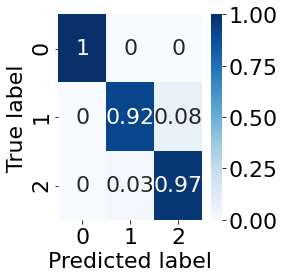

Model trained on: Subject # 0401
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.9817629179331308
Confusion matrix:
[116   0   0]
[ 0 94  5]
[  0   1 113]


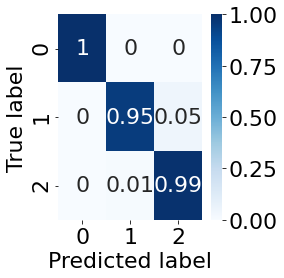

Model trained on: Subject # 0401
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 119]
[113   0   0]
[102   0   0]


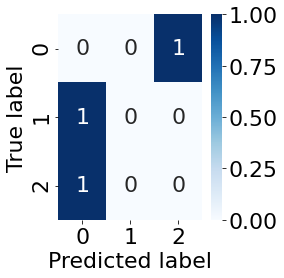

Model trained on: Subject # 0401
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[108   0   0]
[106   0   0]
[120   0   0]


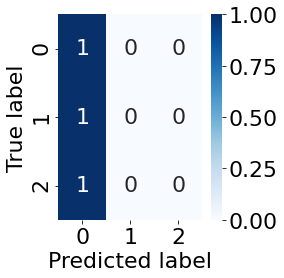

Model trained on: Subject # 0401
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 114]
[119   0   0]
[101   0   0]


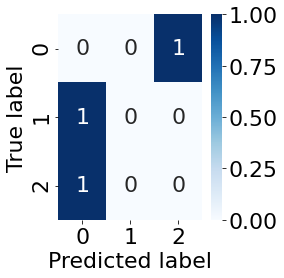

Model trained on: Subject # 0401
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.31137724550898205
Confusion matrix:
[  0   0 113]
[  0   0 117]
[  0   0 104]


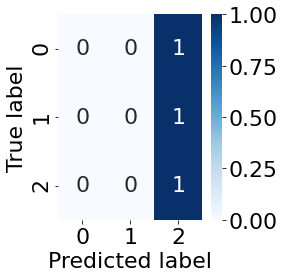

Model trained on: Subject # 0401
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[105   0   0]
[108   0   0]
[121   0   0]


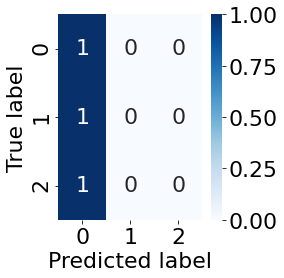

Model trained on: Subject # 0401
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[108   0   0]
[114   0   0]
[112   0   0]


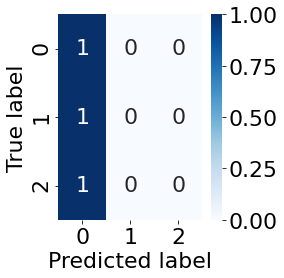

Model trained on: Subject # 0401
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[112   0   0]
[109   0   0]
[113   0   0]


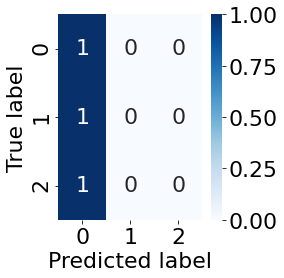

Model trained on: Subject # 0502
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.6796407185628742
Confusion matrix:
[  0   0 107]
[  0 108   0]
[  0   0 119]


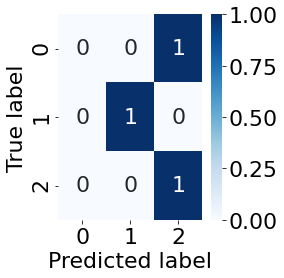

Model trained on: Subject # 0502
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 102]
[  0   0 122]
[110   0   0]


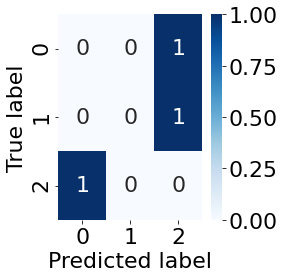

Model trained on: Subject # 0502
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 119]
[103   0   0]
[  0 112   0]


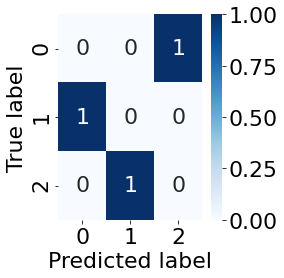

Model trained on: Subject # 0502
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[  0 100   0]
[  0 105   0]
[  0 129   0]


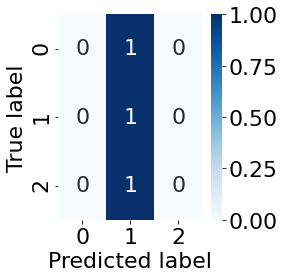

Model trained on: Subject # 0502
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0   0 113]
[  0 112   0]
[  0 109   0]


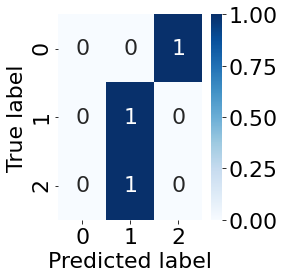

Model trained on: Subject # 0502
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.6676646706586826
Confusion matrix:
[ 0 50 61]
[  0 110   0]
[  0   0 113]


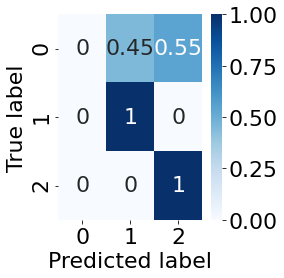

Model trained on: Subject # 0502
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.31736526946107785
Confusion matrix:
[  0 109   0]
[  0 106   0]
[  0 119   0]


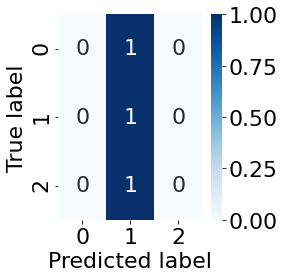

Model trained on: Subject # 0502
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3161094224924012
Confusion matrix:
[104   0   0]
[112   0   0]
[113   0   0]


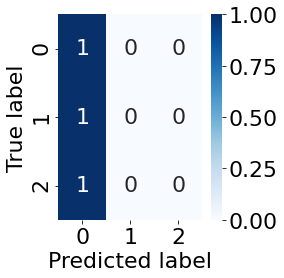

Model trained on: Subject # 0502
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3373860182370821
Confusion matrix:
[111   0   0]
[114   0   0]
[104   0   0]


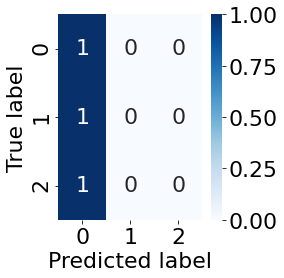

Model trained on: Subject # 0502
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.9970059880239521
Confusion matrix:
[105   0   0]
[  0 112   1]
[  0   0 116]


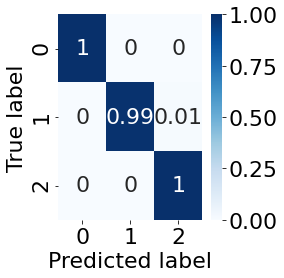

Model trained on: Subject # 0502
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 116]
[  0   0 104]
[114   0   0]


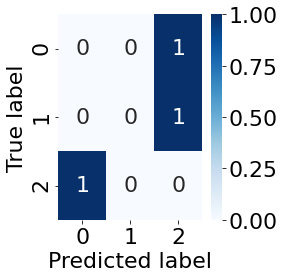

Model trained on: Subject # 0502
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.718562874251497
Confusion matrix:
[118   0   0]
[ 0  0 94]
[  0   0 122]


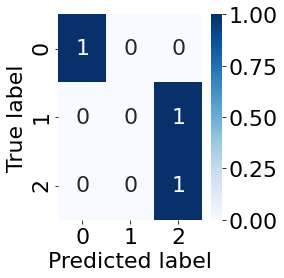

Model trained on: Subject # 0502
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3203592814371258
Confusion matrix:
[107   0   0]
[114   0   0]
[  0 113   0]


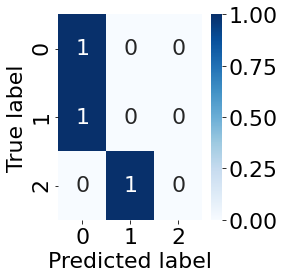

Model trained on: Subject # 0502
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.2964071856287425
Confusion matrix:
[  0 115   0]
[ 0 99  0]
[  0 120   0]


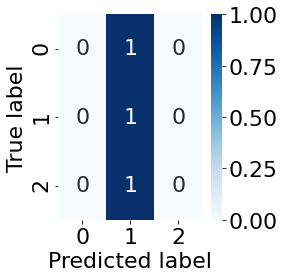

Model trained on: Subject # 0502
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.6736526946107785
Confusion matrix:
[  0 109   0]
[  0 126   0]
[ 0  0 99]


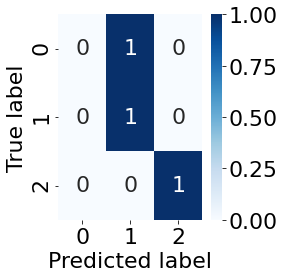

Model trained on: Subject # 0502
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.655688622754491
Confusion matrix:
[108   0   0]
[  0 111   0]
[  0 115   0]


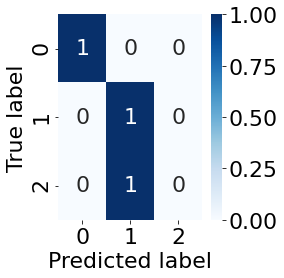

Model trained on: Subject # 0601
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0 119   0]
[  0 108   0]
[  0 107   0]


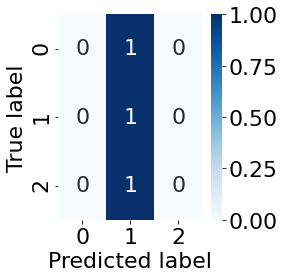

Model trained on: Subject # 0601
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.6407185628742516
Confusion matrix:
[  0 120   0]
[  0 103   0]
[  0   0 111]


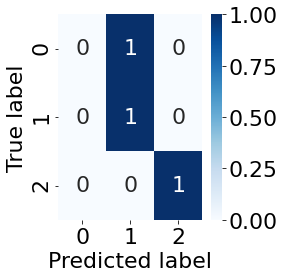

Model trained on: Subject # 0601
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.6826347305389222
Confusion matrix:
[112   0   0]
[  0   0 106]
[  0   0 116]


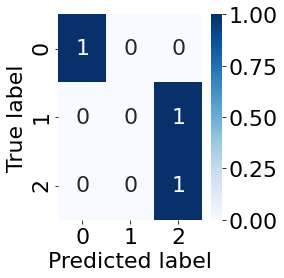

Model trained on: Subject # 0601
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.3592814371257485
Confusion matrix:
[  0 103   0]
[  0 120   0]
[  0 111   0]


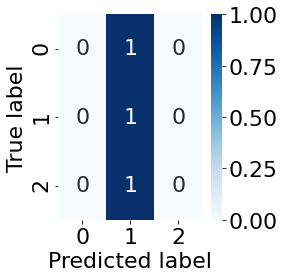

Model trained on: Subject # 0601
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0 105   0]
[  0 108   0]
[  0 121   0]


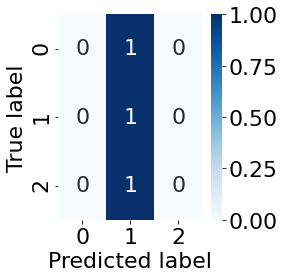

Model trained on: Subject # 0601
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0 109   0]
[  0 112   0]
[  0 113   0]


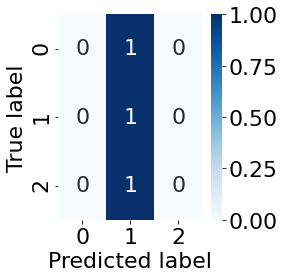

Model trained on: Subject # 0601
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.3413173652694611
Confusion matrix:
[  0 114   0]
[  0 114   0]
[  0 106   0]


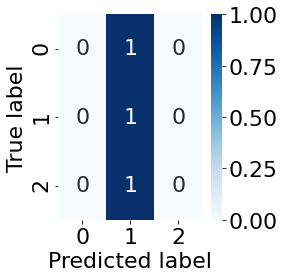

Model trained on: Subject # 0601
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3221884498480243
Confusion matrix:
[  0   0 111]
[  0   0 112]
[  0   0 106]


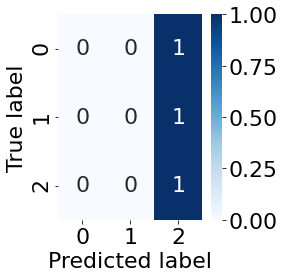

Model trained on: Subject # 0601
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.303951367781155
Confusion matrix:
[  0   0 118]
[  0   0 111]
[  0   0 100]


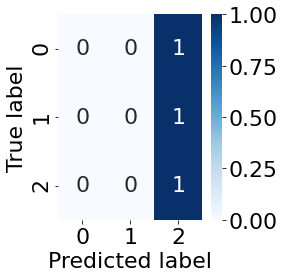

Model trained on: Subject # 0601
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3712574850299401
Confusion matrix:
[  0   0 114]
[  0 124   0]
[ 0 96  0]


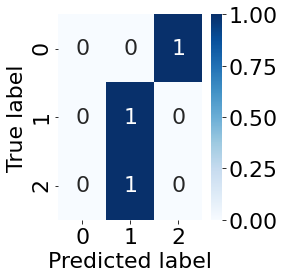

Model trained on: Subject # 0601
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[110   0   0]
[  0 123   0]
[  0   0 101]


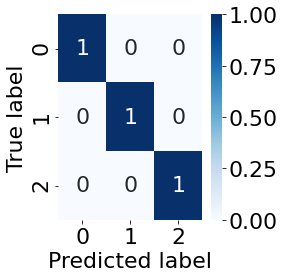

Model trained on: Subject # 0601
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.16167664670658682
Confusion matrix:
[  0   0 105]
[124   0   0]
[51  0 54]


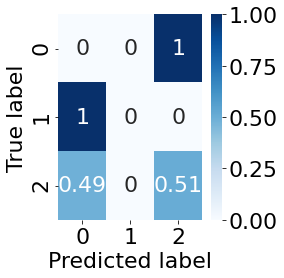

Model trained on: Subject # 0601
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 115]
[  0   0 104]
[  0   0 115]


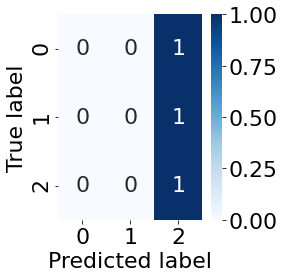

Model trained on: Subject # 0601
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3083832335329341
Confusion matrix:
[  0 117   0]
[  0 103   0]
[  0 114   0]


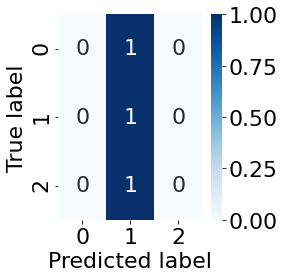

Model trained on: Subject # 0601
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0   0 114]
[  0 108   0]
[  0 112   0]


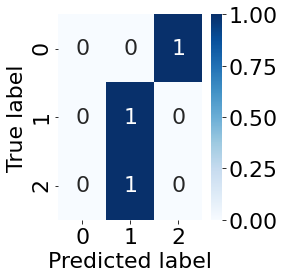

Model trained on: Subject # 0601
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.31736526946107785
Confusion matrix:
[  0   0 116]
[  0 106   0]
[  0 112   0]


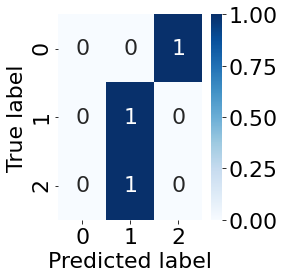

Model trained on: Subject # 0701
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.6586826347305389
Confusion matrix:
[102   0   0]
[114   0   0]
[  0   0 118]


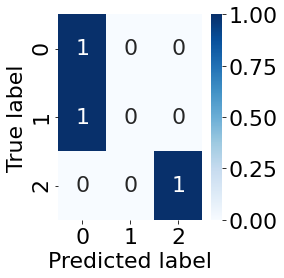

Model trained on: Subject # 0701
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.32934131736526945
Confusion matrix:
[  0 112   0]
[  0 110   0]
[112   0   0]


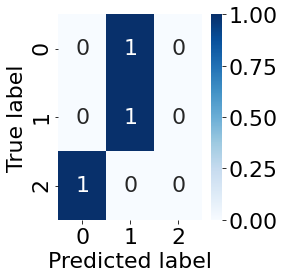

Model trained on: Subject # 0701
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0 113   0]
[103   0   0]
[118   0   0]


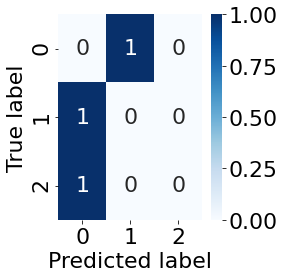

Model trained on: Subject # 0701
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.36826347305389223
Confusion matrix:
[116   0   0]
[109   0   0]
[13 89  7]


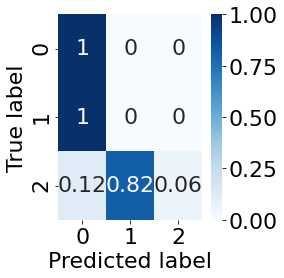

Model trained on: Subject # 0701
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6407185628742516
Confusion matrix:
[110   0   0]
[  0 104   0]
[120   0   0]


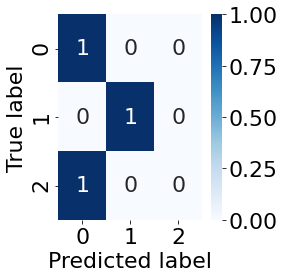

Model trained on: Subject # 0701
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.6646706586826348
Confusion matrix:
[103   0   0]
[  0 119   0]
[  0 112   0]


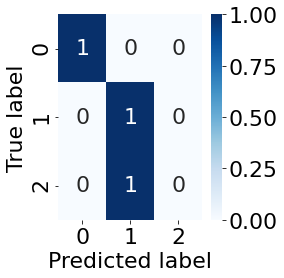

Model trained on: Subject # 0701
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.6826347305389222
Confusion matrix:
[115   0   0]
[  0 107   1]
[26 79  6]


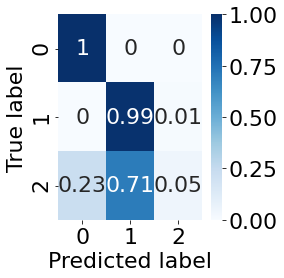

Model trained on: Subject # 0701
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.0
Confusion matrix:
[  0   0 113]
[107   0   0]
[109   0   0]


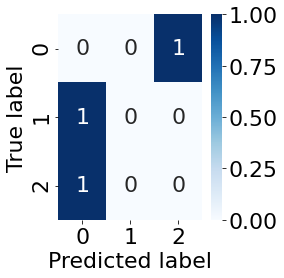

Model trained on: Subject # 0701
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.0
Confusion matrix:
[  0   0 120]
[101   0   0]
[108   0   0]


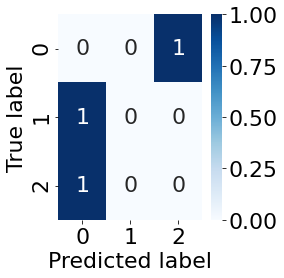

Model trained on: Subject # 0701
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3502994011976048
Confusion matrix:
[117   0   0]
[103   0   0]
[114   0   0]


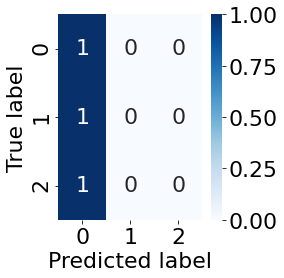

Model trained on: Subject # 0701
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.3023952095808383
Confusion matrix:
[  0 122   0]
[  0   0 111]
[  0   0 101]


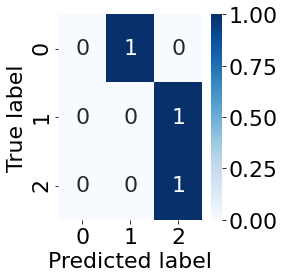

Model trained on: Subject # 0701
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[100   0   0]
[  0 113   0]
[  0   0 121]


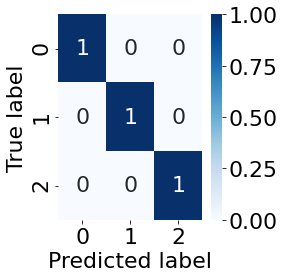

Model trained on: Subject # 0701
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3532934131736527
Confusion matrix:
[118   0   0]
[110   0   0]
[106   0   0]


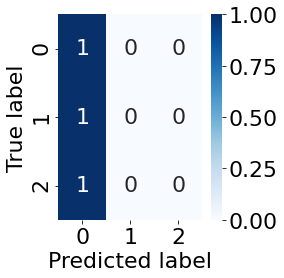

Model trained on: Subject # 0701
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3263473053892216
Confusion matrix:
[  0 111   0]
[  0 109   0]
[  0 114   0]


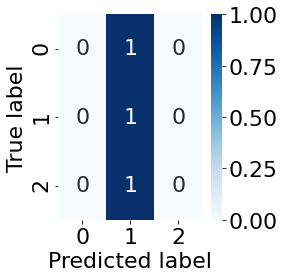

Model trained on: Subject # 0701
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.9011976047904192
Confusion matrix:
[108   0   0]
[  0 118   0]
[ 0 33 75]


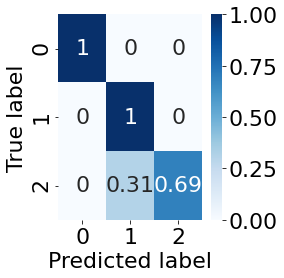

Model trained on: Subject # 0701
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6796407185628742
Confusion matrix:
[116   0   0]
[  0 111   0]
[  0 107   0]


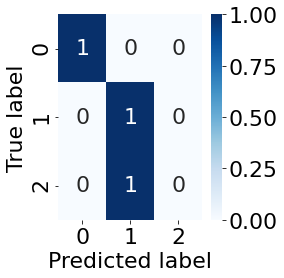

Model trained on: Subject # 0801
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.2844311377245509
Confusion matrix:
[ 10   1 101]
[  6   3 101]
[27  3 82]


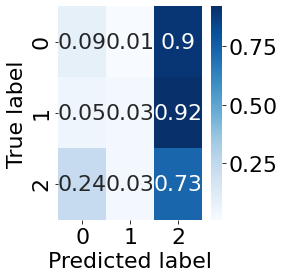

Model trained on: Subject # 0801
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.04491017964071856
Confusion matrix:
[15  2 82]
[  5   0 117]
[113   0   0]


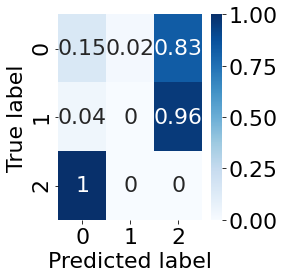

Model trained on: Subject # 0801
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.9610778443113772
Confusion matrix:
[118   3   1]
[  7 107   0]
[ 1  1 96]


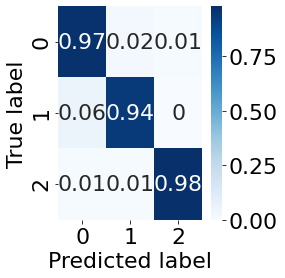

Model trained on: Subject # 0801
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.32934131736526945
Confusion matrix:
[  5   0 113]
[  1   0 109]
[  1   0 105]


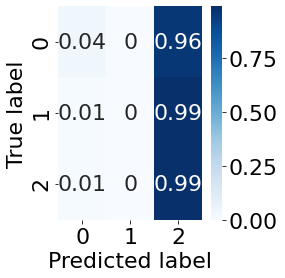

Model trained on: Subject # 0801
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  1   0 108]
[  1   0 112]
[  1   0 111]


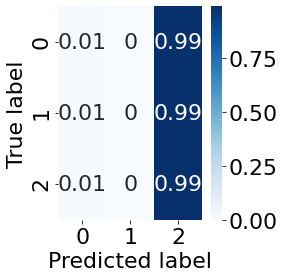

Model trained on: Subject # 0801
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  3   0 104]
[  1   0 108]
[  9   0 109]


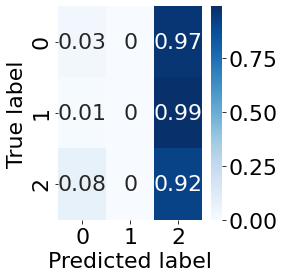

Model trained on: Subject # 0801
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.2934131736526946
Confusion matrix:
[  5   0 117]
[  6   0 108]
[ 5  0 93]


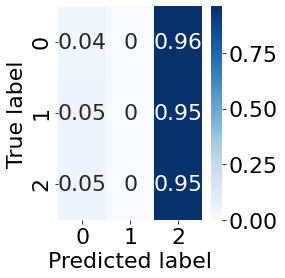

Model trained on: Subject # 0801
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3708206686930091
Confusion matrix:
[122   0   0]
[98  0  0]
[109   0   0]


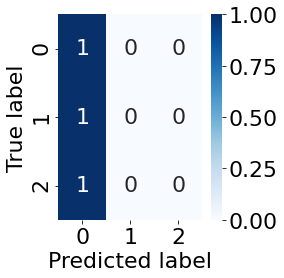

Model trained on: Subject # 0801
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3191489361702128
Confusion matrix:
[105   0   0]
[105   0   0]
[119   0   0]


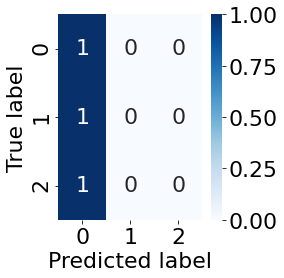

Model trained on: Subject # 0801
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.6616766467065869
Confusion matrix:
[101   0   0]
[  0   0 113]
[  0   0 120]


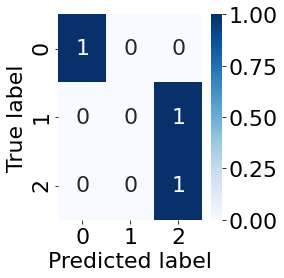

Model trained on: Subject # 0801
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.36227544910179643
Confusion matrix:
[121   0   0]
[  0   0 108]
[105   0   0]


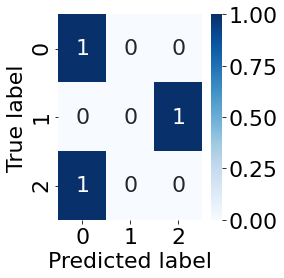

Model trained on: Subject # 0801
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[115   0   0]
[117   0   0]
[102   0   0]


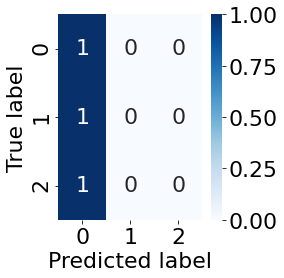

Model trained on: Subject # 0801
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.9820359281437125
Confusion matrix:
[107   0   0]
[  6 112   0]
[  0   0 109]


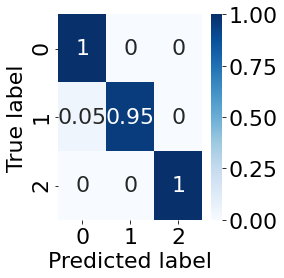

Model trained on: Subject # 0801
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0   0 124]
[ 0  0 98]
[  0   0 112]


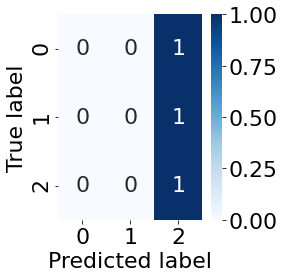

Model trained on: Subject # 0801
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.3143712574850299
Confusion matrix:
[  1   0 114]
[  0   0 115]
[  0   0 104]


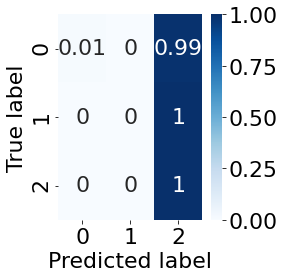

Model trained on: Subject # 0801
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6796407185628742
Confusion matrix:
[115   0   0]
[  0   0 107]
[  0   0 112]


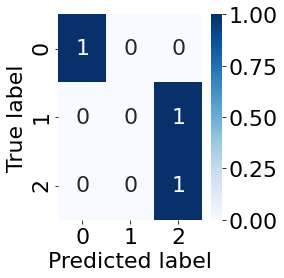

Model trained on: Subject # 0901
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0   0 110]
[112   0   0]
[  0   0 112]


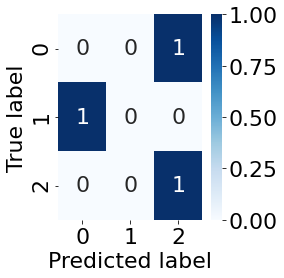

Model trained on: Subject # 0901
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.3263473053892216
Confusion matrix:
[  0   0 106]
[  0   0 119]
[  0   0 109]


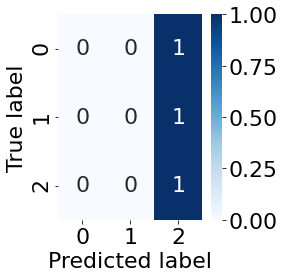

Model trained on: Subject # 0901
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 114]
[  0   0 111]
[109   0   0]


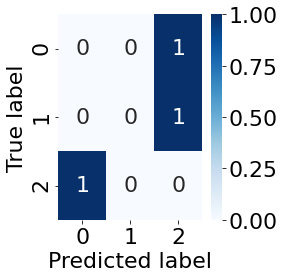

Model trained on: Subject # 0901
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.3652694610778443
Confusion matrix:
[122   0   0]
[116   0   0]
[96  0  0]


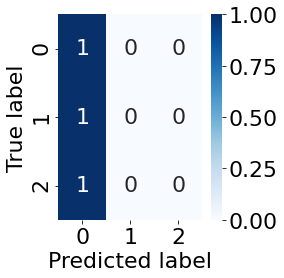

Model trained on: Subject # 0901
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[ 0  0 94]
[121   0   0]
[119   0   0]


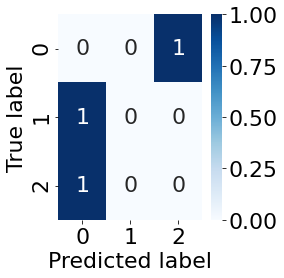

Model trained on: Subject # 0901
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.3473053892215569
Confusion matrix:
[  0   0 113]
[  0   0 105]
[  0   0 116]


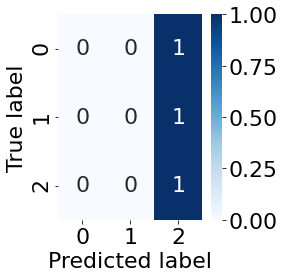

Model trained on: Subject # 0901
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.36826347305389223
Confusion matrix:
[123   0   0]
[106   0   0]
[105   0   0]


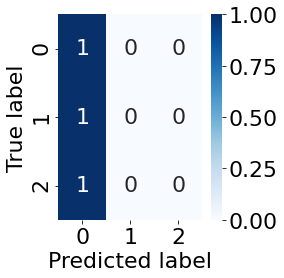

Model trained on: Subject # 0901
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3556231003039514
Confusion matrix:
[  0   0 114]
[ 0  0 98]
[  0   0 117]


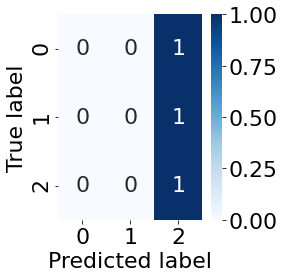

Model trained on: Subject # 0901
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3191489361702128
Confusion matrix:
[  0   0 114]
[  0   0 110]
[  0   0 105]


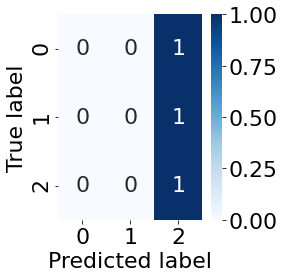

Model trained on: Subject # 0901
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 108]
[  0   0 111]
[  0   0 115]


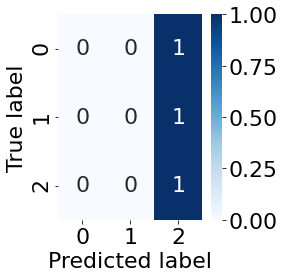

Model trained on: Subject # 0901
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 111]
[  0   0 108]
[  0   0 115]


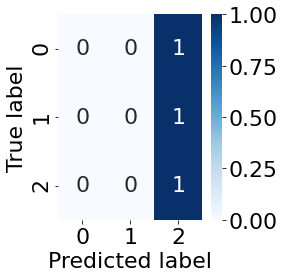

Model trained on: Subject # 0901
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 112]
[  0   0 107]
[  0   0 115]


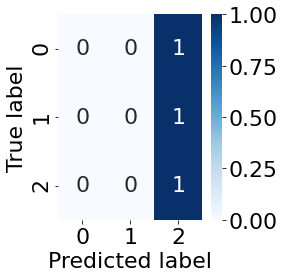

Model trained on: Subject # 0901
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.008982035928143712
Confusion matrix:
[  3   0 105]
[106   0   0]
[120   0   0]


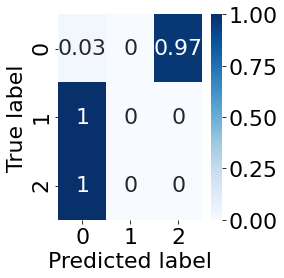

Model trained on: Subject # 0901
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[103   0   0]
[  0 115   0]
[  0   0 116]


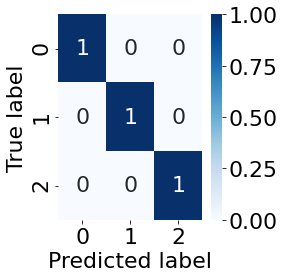

Model trained on: Subject # 0901
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[114   0   0]
[108   0   0]
[  0   0 112]


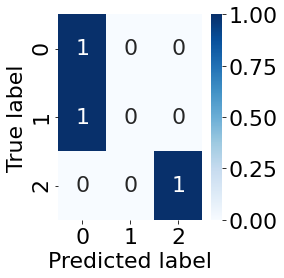

Model trained on: Subject # 0901
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.6616766467065869
Confusion matrix:
[  0   0 113]
[ 0 93  0]
[  0   0 128]


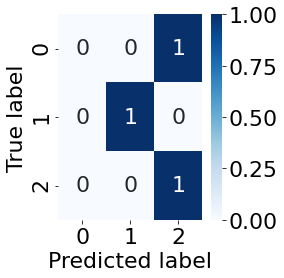

Model trained on: Subject # 1101
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.3383233532934132
Confusion matrix:
[  0   0 121]
[100   0   0]
[  0   0 113]


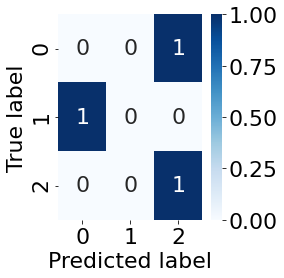

Model trained on: Subject # 1101
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.3712574850299401
Confusion matrix:
[ 0  0 96]
[  0   0 114]
[  0   0 124]


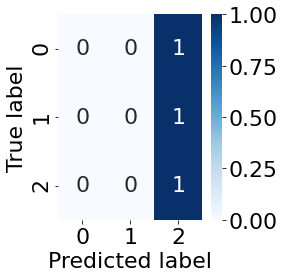

Model trained on: Subject # 1101
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 106]
[116   0   0]
[112   0   0]


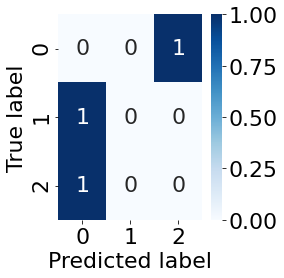

Model trained on: Subject # 1101
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.6646706586826348
Confusion matrix:
[105   0   0]
[  0 117   0]
[  0 112   0]


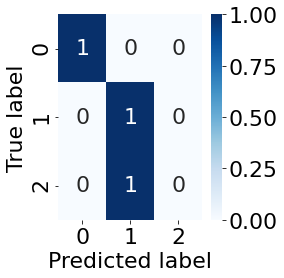

Model trained on: Subject # 1101
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.6766467065868264
Confusion matrix:
[119   0   0]
[  0 107   0]
[108   0   0]


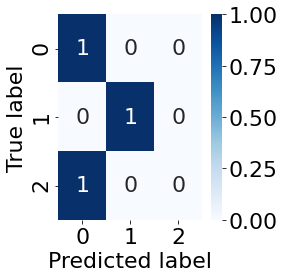

Model trained on: Subject # 1101
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.344311377245509
Confusion matrix:
[  0   0 114]
[  0   6 105]
[  0   0 109]


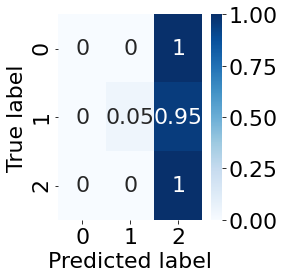

Model trained on: Subject # 1101
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.6946107784431138
Confusion matrix:
[112   0   0]
[  0 120   0]
[  0 102   0]


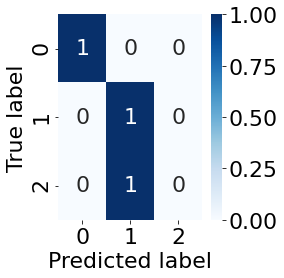

Model trained on: Subject # 1101
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3282674772036474
Confusion matrix:
[  0   0 103]
[  0   0 118]
[  0   0 108]


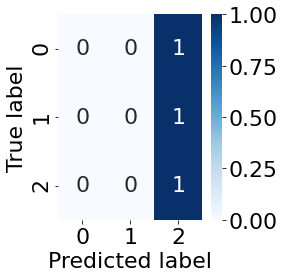

Model trained on: Subject # 1101
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.303951367781155
Confusion matrix:
[  0   0 113]
[  0   0 116]
[  0   0 100]


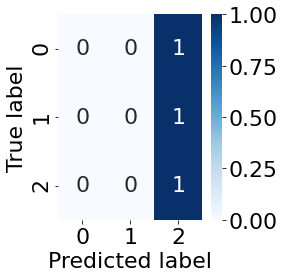

Model trained on: Subject # 1101
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.33532934131736525
Confusion matrix:
[  0   0 113]
[  6   0 103]
[  0   0 112]


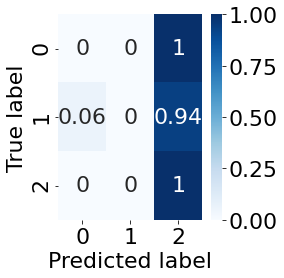

Model trained on: Subject # 1101
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.32335329341317365
Confusion matrix:
[  0   0 110]
[  0   0 116]
[  0   0 108]


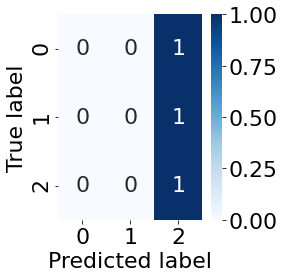

Model trained on: Subject # 1101
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.3592814371257485
Confusion matrix:
[  0   0 105]
[  0   0 109]
[  0   0 120]


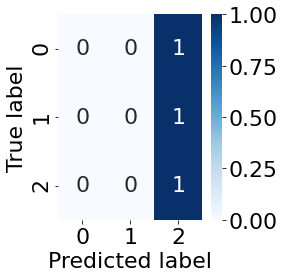

Model trained on: Subject # 1101
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3083832335329341
Confusion matrix:
[103   0   0]
[109   0   0]
[122   0   0]


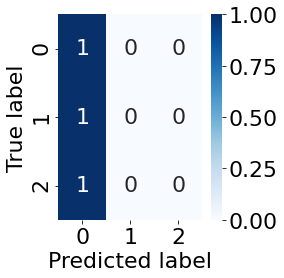

Model trained on: Subject # 1101
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.3323353293413174
Confusion matrix:
[  0 113   0]
[  0 111   0]
[  0 110   0]


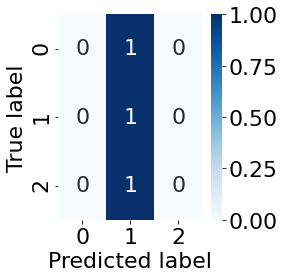

Model trained on: Subject # 1101
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[118   0   0]
[  0 107   0]
[  0   0 109]


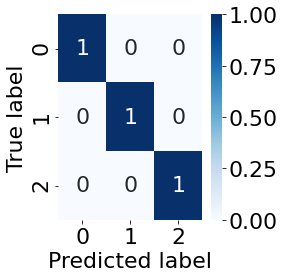

Model trained on: Subject # 1101
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 0.3413173652694611
Confusion matrix:
[  0   0 120]
[  0 114   0]
[  0 100   0]


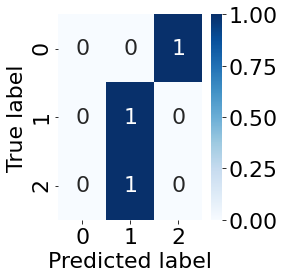

Model trained on: Subject # 1301
Predicted on:     Subject # 0002
Test samples: 334
Accuracy: 0.27844311377245506
Confusion matrix:
[92  0 23]
[98  0 18]
[102   0   1]


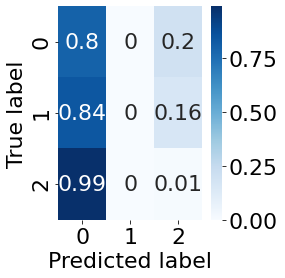

Model trained on: Subject # 1301
Predicted on:     Subject # 0004
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 107]
[  0   0 110]
[117   0   0]


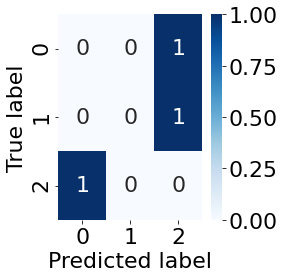

Model trained on: Subject # 1301
Predicted on:     Subject # 0005
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 112]
[114   0   0]
[108   0   0]


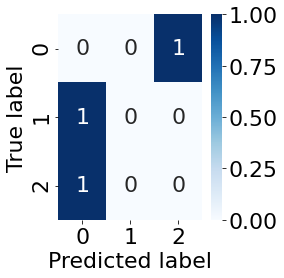

Model trained on: Subject # 1301
Predicted on:     Subject # 0006
Test samples: 334
Accuracy: 0.6616766467065869
Confusion matrix:
[108   0   1]
[86  0 26]
[  0   0 113]


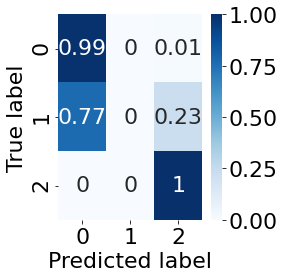

Model trained on: Subject # 1301
Predicted on:     Subject # 0007
Test samples: 334
Accuracy: 0.3023952095808383
Confusion matrix:
[101   0   0]
[  0   0 125]
[108   0   0]


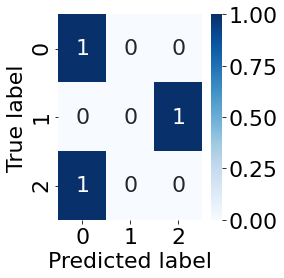

Model trained on: Subject # 1301
Predicted on:     Subject # 0009
Test samples: 334
Accuracy: 0.4431137724550898
Confusion matrix:
[38  0 78]
[  0   0 108]
[  0   0 110]


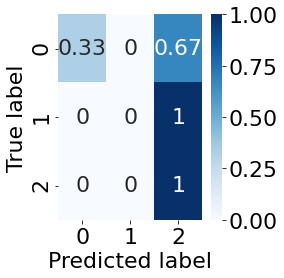

Model trained on: Subject # 1301
Predicted on:     Subject # 0013
Test samples: 334
Accuracy: 0.6467065868263473
Confusion matrix:
[114   0   0]
[  0   0 118]
[  0   0 102]


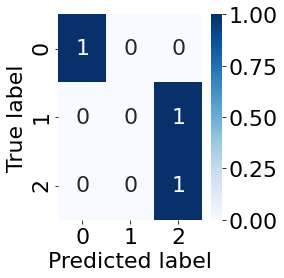

Model trained on: Subject # 1301
Predicted on:     Subject # 0201
Test samples: 329
Accuracy: 0.3343465045592705
Confusion matrix:
[110   0   0]
[105   0   0]
[114   0   0]


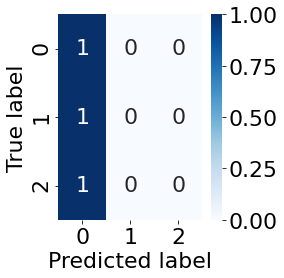

Model trained on: Subject # 1301
Predicted on:     Subject # 0401
Test samples: 329
Accuracy: 0.3434650455927052
Confusion matrix:
[113   0   0]
[106   0   0]
[110   0   0]


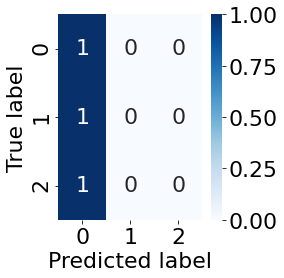

Model trained on: Subject # 1301
Predicted on:     Subject # 0502
Test samples: 334
Accuracy: 0.3383233532934132
Confusion matrix:
[113   0   0]
[110   0   0]
[111   0   0]


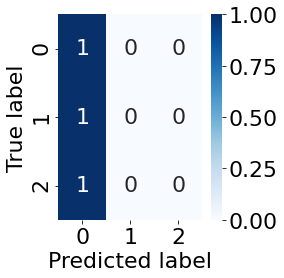

Model trained on: Subject # 1301
Predicted on:     Subject # 0601
Test samples: 334
Accuracy: 0.0
Confusion matrix:
[  0   0 105]
[118   0   1]
[110   0   0]


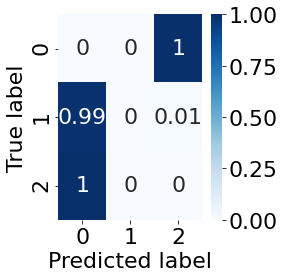

Model trained on: Subject # 1301
Predicted on:     Subject # 0701
Test samples: 334
Accuracy: 0.32934131736526945
Confusion matrix:
[110   0   0]
[  0   0 108]
[116   0   0]


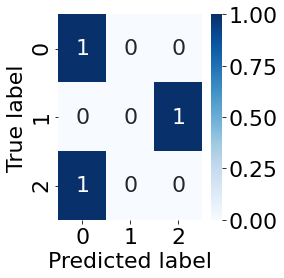

Model trained on: Subject # 1301
Predicted on:     Subject # 0801
Test samples: 334
Accuracy: 0.3413173652694611
Confusion matrix:
[114   0   0]
[93  0  0]
[127   0   0]


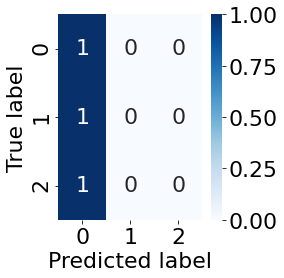

Model trained on: Subject # 1301
Predicted on:     Subject # 0901
Test samples: 334
Accuracy: 0.6616766467065869
Confusion matrix:
[  0   0 113]
[  0 115   0]
[  0   0 106]


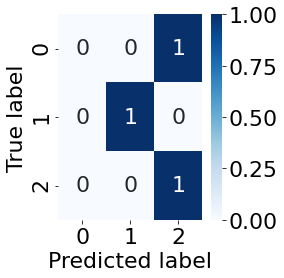

Model trained on: Subject # 1301
Predicted on:     Subject # 1101
Test samples: 334
Accuracy: 0.5
Confusion matrix:
[100   0   0]
[  0   0 115]
[52  0 67]


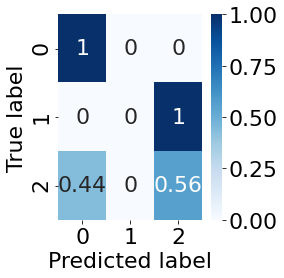

Model trained on: Subject # 1301
Predicted on:     Subject # 1301
Test samples: 334
Accuracy: 1.0
Confusion matrix:
[115   0   0]
[  0 112   0]
[  0   0 107]


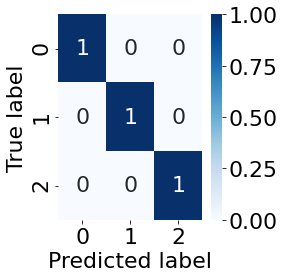

In [25]:
matr = [[0]*16 for i in range(16)]
tr = 0
te = 0
subs = ['0002','0004','0005','0006','0007','0009','0013','0201',
    #    0      1      2      3      4      5      6      7
        '0401','0502','0601','0701','0801','0901','1101','1301']
    #    8      9      10     11     12     13     14     15
for train in subs:
    te = 0
    for test in subs:
        # Load the trained model from disk
        mod = '..\data\data3_attention\cnn_attention_'+train+'.h5'
        model_cnn.load_weights(mod)
        print("Model trained on: Subject #", train)
        print("Predicted on:     Subject #", test)
        valid_images, valid_labels = get_test_data("attention_"+test+"_low_fp1fp2_2s_resampled500Hz.pkl")
        accuracy, con_mat = mypredict(valid_images)
        matr[tr][te] = accuracy
        te += 1
    tr += 1

Text(0.5, 68.0, 'Predict set')

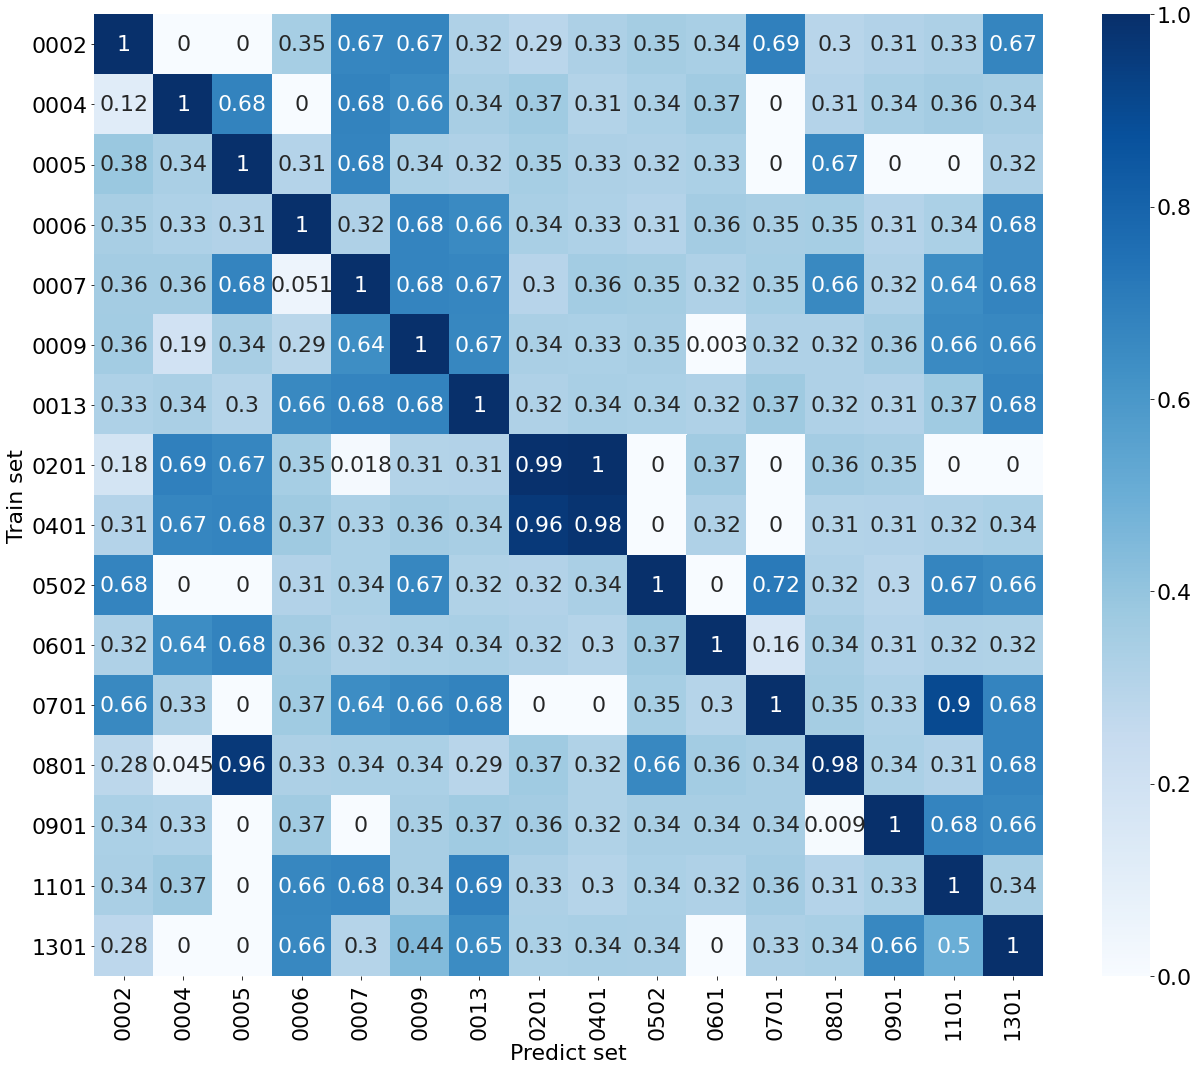

In [29]:
matr_df = pd.DataFrame(matr, index = subs, columns = subs)
figure = plt.figure(figsize=(18,15))
sns.heatmap(matr_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('Train set')
plt.xlabel('Predict set')